# Examining Crime Rates Surrounding Dispensaries
## EDA and ARIMA Modeling

In this notebook, we will be exploring the data surrounding crimes in Los Angeles and their proximity to Medical Marijuana dispensaries. Part of our exploration of the data will include an analysis of change over time, from before Marijuana was legalized to after it was legalized. We will be using an ARIMA model to predict crime within a half mile radius of each dispensary for 2019. 

We will be using dispensary locations queried from Yelp's api, and crime data downloaded from the City of LA. Currently, we have a dataset of 162 dispensaries and a dataset of just under 2 million crimes. We foresee problems mapping out that many crimes, so we will be sampling 20,000 crimes randomly, without replacement, from the two years leading up to legalization to present day. 

Two of the main opposition points to marijuana legalization were as follows: 

1. Increase black market and cartel activity.
1. Proposition 64 is an all-out assault on underprivileged neighborhoods already reeling from alcohol and drug addiction problems.

We are generalizing these into one problem statement suggesting that violence will increase with the presence of legal marijuana dispensaries. We plan to examine the data for ourselves and analyze the validity behind these claims. 

Importing Necessary Modules.

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline
plt.style.use('fivethirtyeight')

Reading in pickled crime datasets, one for each year. 

In [13]:
# with open('../assets/crime_2015.pkl', 'rb') as f:
#     crime_2015_pkl = pickle.load(f)
# with open('../assets/crime_2016.pkl', 'rb') as f:
#     crime_2016_pkl = pickle.load(f)
# with open('../assets/crime_2017.pkl', 'rb') as f:
#     crime_2017_pkl = pickle.load(f)
# with open('../assets/crime_2018.pkl', 'rb') as f:
#     crime_2018_pkl = pickle.load(f)

Reading in crime data from csv. 

In [14]:
crime_2015 = pd.read_csv('../data/crime_2015.csv')
crime_2016 = pd.read_csv('../data/crime_2016.csv')
crime_2017 = pd.read_csv('../data/crime_2017.csv')
crime_2018 = pd.read_csv('../data/crime_2018.csv')

In [16]:
crime_2015.drop(['Unnamed: 0', 'location_'], axis = 1, inplace = True)
crime_2016.drop(['Unnamed: 0', 'location_'], axis = 1, inplace = True)
crime_2017.drop(['Unnamed: 0', 'location_'], axis = 1, inplace = True)
crime_2018.drop(['Unnamed: 0', 'location_'], axis = 1, inplace = True)

Reading in dispensary csv.

In [18]:
df_weed = pd.read_csv('../data/df_weed.csv')

In [19]:
df_weed.drop('Unnamed: 0', axis = 1, inplace = True)

In [20]:
df_weed.head()

,name,is_closed,url,rating,price,review_count,latitude,longitude,location
0,Extra Special Delivery,False,https://www.yelp.com/biz/extra-special-deliver...,5.0,$,68,34.166720,-118.375185,"(34.1667203, -118.3751849)"
1,Ganjarunner,False,https://www.yelp.com/biz/ganjarunner-los-angel...,5.0,NaN,51,34.101610,-118.302060,"(34.10161, -118.30206)"
2,The Higher Path,False,https://www.yelp.com/biz/the-higher-path-sherm...,4.5,$$,149,34.149339,-118.439875,"(34.1493390052598, -118.439874686508)"
3,Kushfly,False,https://www.yelp.com/biz/kushfly-los-angeles-2...,4.0,$$,147,34.127600,-118.346690,"(34.1276, -118.34669)"
4,MedMen West Hollywood,False,https://www.yelp.com/biz/medmen-west-hollywood...,4.0,$$,323,34.090591,-118.367290,"(34.0905911417357, -118.367290442404)"


In [21]:
crime_2015.head()

,date_occurred,area_name,crime_code_description,weapon_description,lat,long
0,2015-01-01,N Hollywood,BURGLARY,unknown,34.1608,-118.3774
1,2015-01-01,Rampart,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0398,-118.2780
2,2015-01-01,Newton,THEFT OF IDENTITY,unknown,33.9975,-118.2478
3,2015-01-01,Hollywood,BATTERY ON A FIREFIGHTER,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.1016,-118.3361
4,2015-01-01,Wilshire,THEFT OF IDENTITY,unknown,34.0440,-118.3586


Looking at datatypes of the crime 2015 dataset. 

In [22]:
crime_2015.dtypes

date_occurred              object
area_name                  object
crime_code_description     object
weapon_description         object
lat                       float64
long                      float64
dtype: object

Writing a function to change latitude and longitude data to numtypes so we can analyze them numerically, add create a 'count' column that populates with 1, and resets the index as 'date occurred'.

In [23]:
def to_num_type(df, col_1, col_2):
    df[[col_1, col_2]] = df[[col_1, col_2]].apply(pd.to_numeric)
    df = df[df['lat'] != 0]
    df['count'] = 1
    df = df.set_index('date_occurred')
    return df

In [24]:
crime_2015 = to_num_type(crime_2015, 'lat', 'long')

In [25]:
crime_2016 = to_num_type(crime_2016, 'lat', 'long')

In [26]:
crime_2017 = to_num_type(crime_2017, 'lat', 'long')

In [27]:
crime_2018 = to_num_type(crime_2018, 'lat', 'long')

Below we are creating a function to plot out line plots displaying the daily crime count during each year. 

In [28]:
def plot_crime_count(df, title, color = 'C0'):  
    fig, ax = plt.subplots(figsize = (20,10))
    plt.plot(df.groupby([df.index, 'count']).size().unstack('count'), color = color)
    plt.title(title, fontsize = 30)
    plt.xlabel('\nMonths', fontsize = 25)
    plt.ylabel('Count', fontsize = 25)
    plt.yticks(fontsize = 20)
    ax.set_xticks(range(0, 365, 30))
#     ax.xaxis.set_ticks(365/30)
    ax.xaxis.set_ticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], fontsize = 20, rotation = 20)
    plt.tight_layout()
    #plt.savefig('../plots/crime_count_by_day')
    #     plt.xticks(np.arange(1,1000, step = 80), calendar.month_name[1:13], rotation=20)

In [29]:
crime_2015.groupby([crime_2015.index, 'count']).size().sort_values(ascending = False).head(13)

date_occurred  count
2015-01-01     1        1390
2015-11-01     1         916
2015-06-01     1         888
2015-08-01     1         879
2015-05-01     1         852
2015-09-01     1         846
2015-12-01     1         828
2015-10-01     1         824
2015-03-01     1         824
2015-07-01     1         815
2015-04-01     1         786
2015-02-01     1         758
2015-10-31     1         744
dtype: int64

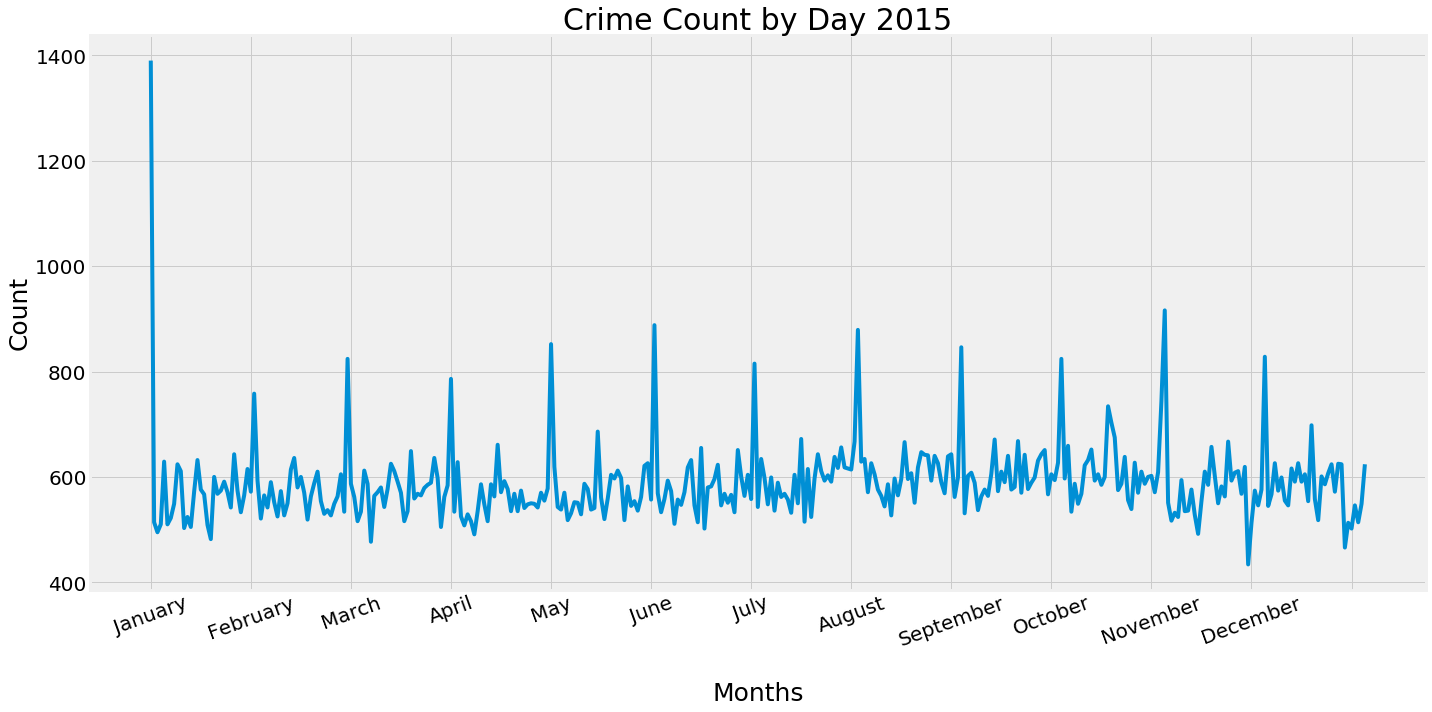

In [30]:
plot_crime_count(crime_2015, 'Crime Count by Day 2015', color = 'C0')

Above, we can see that there are quite a few spikes during 2015. The highest crime day of the year is new years day, which makes sense as it is a 'party day' and people decide to go buck wild when they can. It is still quite interesting that there are almost twice as many crimes on new years day as any other spikes during the year. The rest of the spikes happen on the first of each month. It is an interesting trend that we expect to see continue each year. 

In [31]:
crime_2016.groupby([crime_2016.index, 'count']).size().sort_values(ascending = False).head(13)

date_occurred  count
2016-01-01     1        1300
2016-08-01     1         895
2016-11-01     1         894
2016-09-01     1         887
2016-04-01     1         882
2016-06-01     1         870
2016-02-01     1         869
2016-07-01     1         863
2016-10-01     1         856
2016-05-01     1         833
2016-03-01     1         813
2016-12-01     1         800
2016-04-15     1         744
dtype: int64

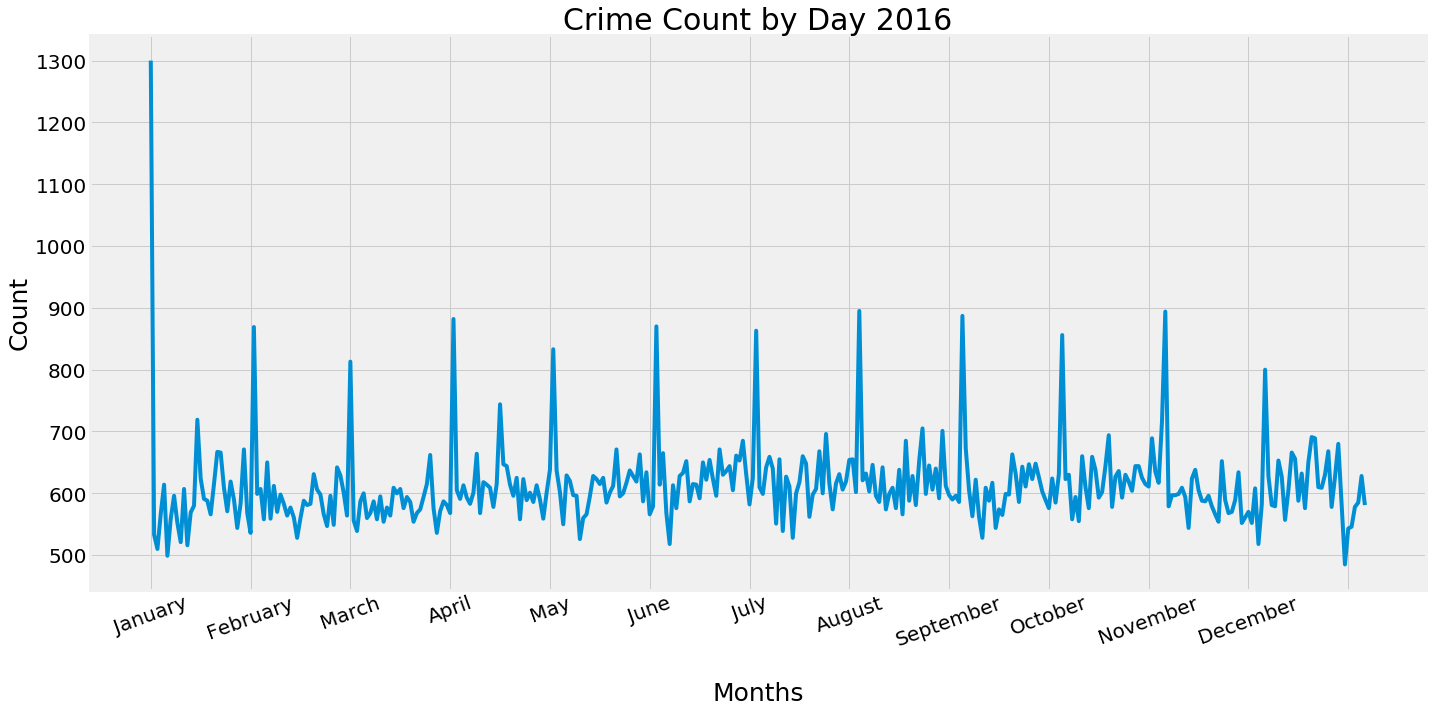

In [32]:
plot_crime_count(crime_2016, 'Crime Count by Day 2016', color = 'C0')

Similar to 2015, we see the highest crime day of the year on January 1st in 2016. However, the total crimes on january first has decreased by about 100. Another similar trend is that the highest crime day of each month following is the first of that month. 

In [33]:
crime_2017.groupby([crime_2017.index, 'count']).size().sort_values(ascending = False).head(13)

date_occurred  count
2017-01-01     1        1158
2017-09-01     1         966
2017-06-01     1         890
2017-12-01     1         884
2017-05-01     1         869
2017-11-01     1         850
2017-03-01     1         841
2017-10-01     1         838
2017-02-01     1         826
2017-07-01     1         819
2017-05-26     1         806
2017-08-01     1         801
2017-04-01     1         794
dtype: int64

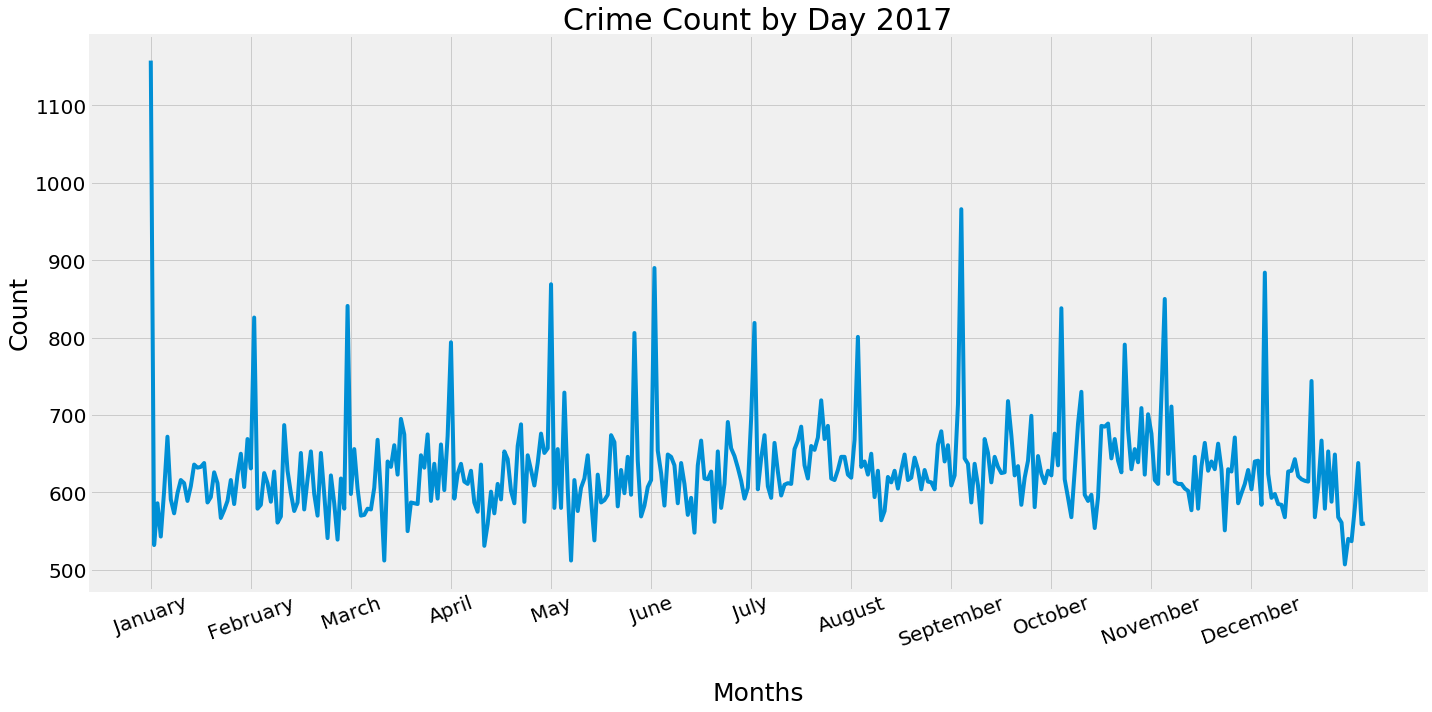

In [34]:
plot_crime_count(crime_2017, 'Crime Count by Day 2017', color = 'C0')

The trend continues in 2017, with the highest crime day of the year being January first, and the highest crime day of each month being the first of that month. The number of crimes on January first decreased by about 150 from 2016. 

In [35]:
crime_2018.groupby([crime_2018.index, 'count']).size().sort_values(ascending = False).head(13)

date_occurred  count
2018-01-01     1        946
2018-08-01     1        837
2018-06-01     1        836
2018-02-01     1        823
2018-05-01     1        805
2018-04-01     1        788
2018-10-01     1        784
2018-11-01     1        768
2018-09-01     1        744
2018-03-01     1        735
2018-02-16     1        730
2018-10-28     1        726
2018-05-18     1        713
dtype: int64

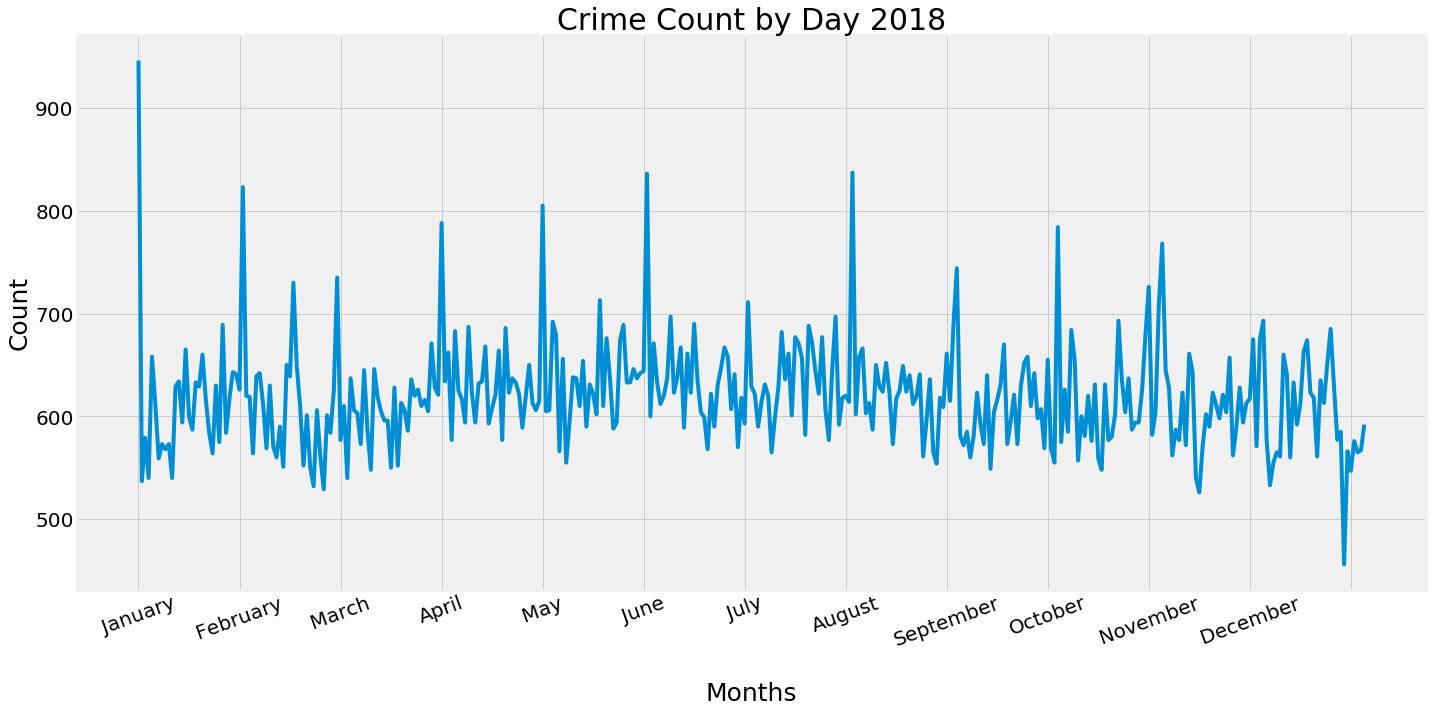

In [36]:
plot_crime_count(crime_2018, 'Crime Count by Day 2018', color = 'C0')

The trend continues in 2018, however, the total crimes on January first has decreased significantly, to under 1000. The trend of the first of each month being the day with the most crimes continues to be true. 

Looking at all of the graphs above, we've tried to interpret why there are such steep spikes at the beginning of every month. There are a few ideas we have. Rent is due on the first, so petty theft and burglary will spike as people feel the need to protect their lifestyle. Desperate people are most likely to commit these crimes when they need money the most, which makes sense for the beginning of each month.

Writing a Function to plot crime distributions by day per year. 

In [37]:
def plot_crime_dist(df, title, color='C0'): 
    plt.figure(figsize = (20,10))
    plt.hist(df.groupby([df.index, 'count']).size().unstack('count')[1], bins = 52, color = color);
    plt.axvline(df.groupby([df.index, 'count']).size().unstack('count')[1].mean(), color = 'C1')
    plt.title(title, fontsize = 30)
    plt.xlabel('Number of Crimes', fontsize = 25)
    plt.ylabel('Frequency', fontsize = 25)

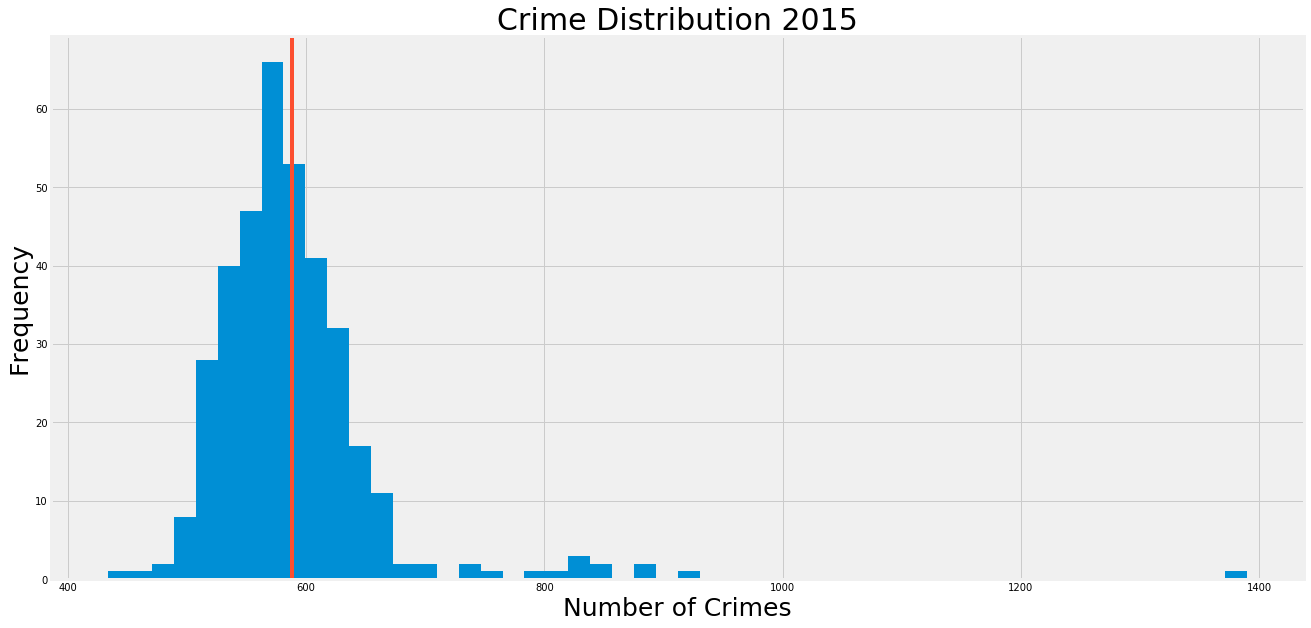

In [38]:
plot_crime_dist(crime_2015, 'Crime Distribution 2015', color = 'C0')


Above, we can see a pretty normal distribution of crimes, with some extreme right skew due to outliers.  The mean number of crimes per day was just below 600, with a max of just under 1400 in a day and a min of about 450 in a day. 

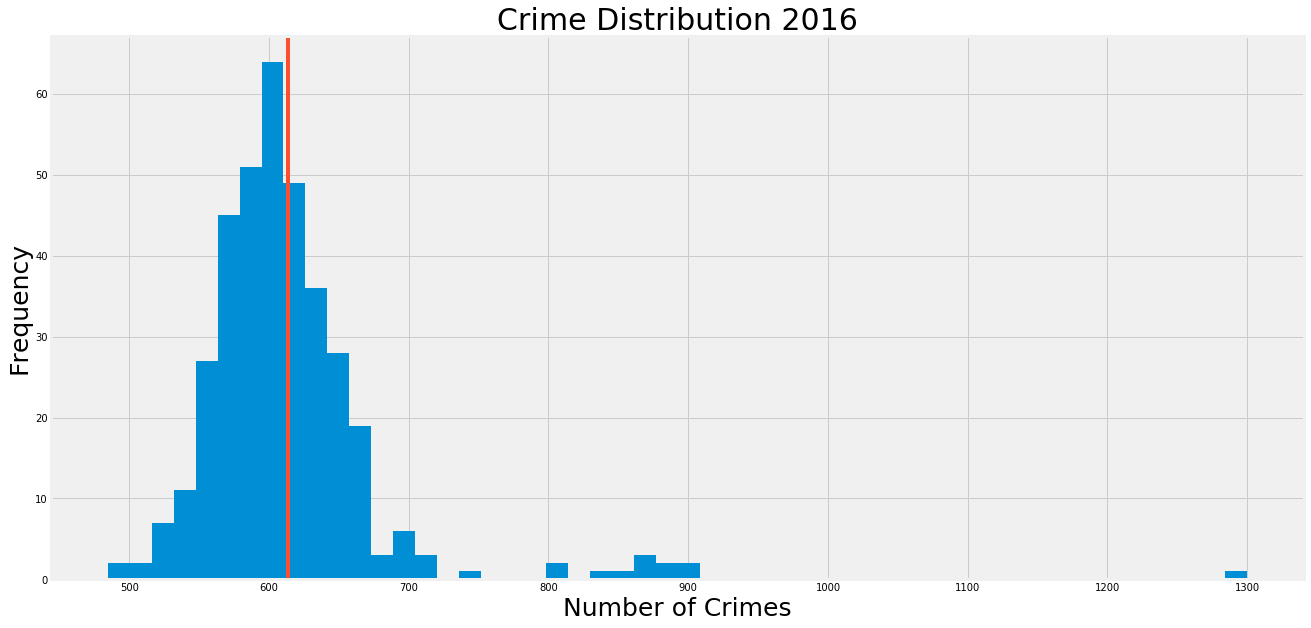

In [39]:
plot_crime_dist(crime_2016, 'Crime Distribution 2016', color = 'C0')

Just like above, we can see another normal distribution with some right skew due to extreme outliers. We have a maximum crime count of just under 1300 and a minimum of just under 500. Our mode and our mean are almost the same, sitting around 600 and just above 600, respectively. 

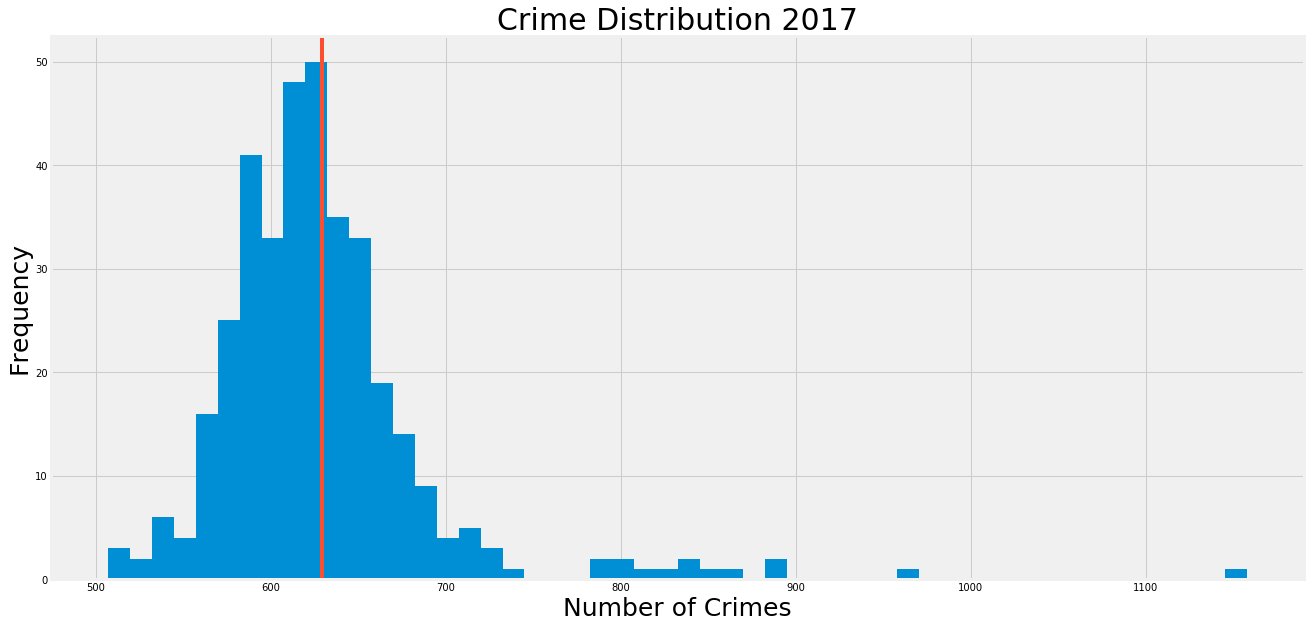

In [40]:
plot_crime_dist(crime_2017, 'Crime Distribution 2017', color = 'C0')


In 2017, our mean and our mode increased a bit, but our outliers decreased. Our minimum number of crimes per day increased to above 500, and our maximum number of crimes per day decreased to 1150. Our distribution is still pretty normal, with a spike to the left of the mode, at 590. 

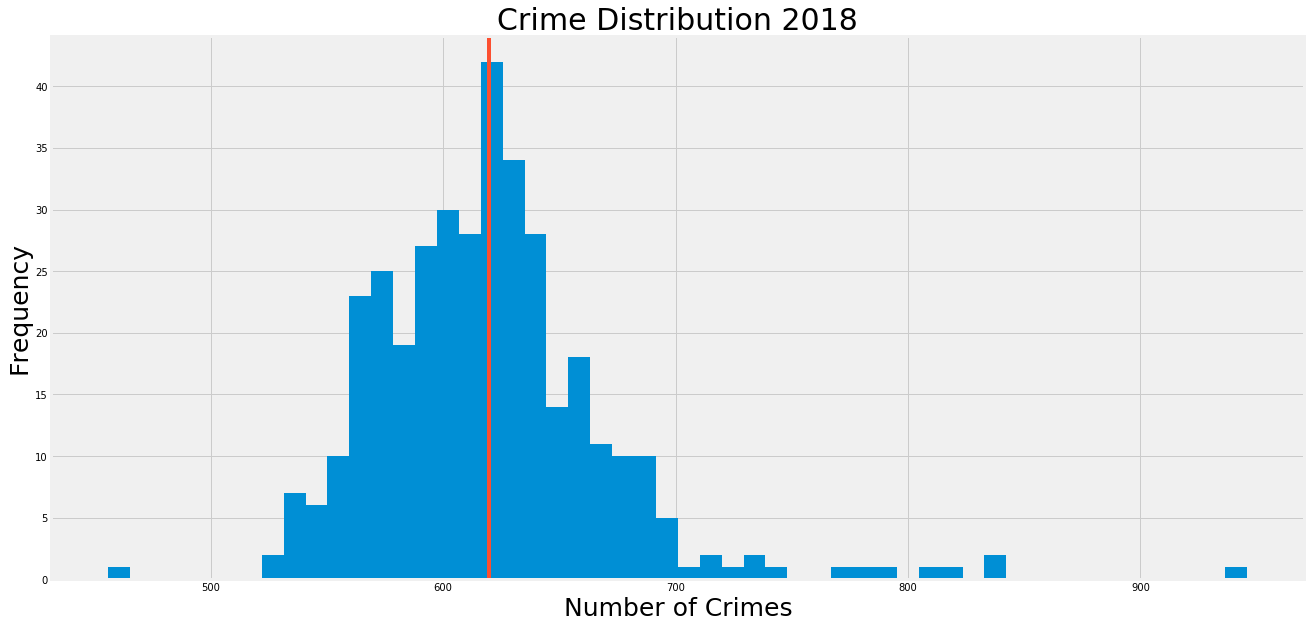

In [41]:
plot_crime_dist(crime_2018, 'Crime Distribution 2018', color = 'C0')

Our 2018 crime data is the least normal of the years, skewed to the right. The maximum crimes committed in a day was around 950, which was a significant drop from the previous years. The minimum number of crimes was around 450, which dropped from 2017. 

So Far, all of our data as been strictly related to crime around Los Angeles. We wanted to look at the actual crime data before looking at crime in relation to dispensary locations. 


Creating a function to create our crime and dispensary plots coordinate plots.

In [42]:
def crime_disp_map(df_crime, df_disp, title):
    fig, ax = plt.subplots(figsize =(15,12))
    plt.scatter(df_crime['long'], df_crime['lat'], color='C0', label='LA City Crimes', s = .5, alpha = .3)
    ax.scatter(df_disp['longitude'], df_disp['latitude'], color='C1', label='Dispensaries', s = 10)
    plt.title(title, fontsize=28)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    ax.legend(fontsize=20);

Creating another weed df that masks dispensaries that are far out from los angeles that were still in the dataset. 

In [43]:
df_weed_2 = df_weed.drop(df_weed[((df_weed['longitude']>-118.2) & (df_weed['latitude']<33.9))|
       (df_weed['longitude']<-118.7) | (df_weed['latitude']>34.35) | (df_weed['longitude'] >-118.18)].index)

The graphs below will essentially all look the same, as the crime counts in Los Angeles are rampant each year. We will analyze all of them following the last one. 

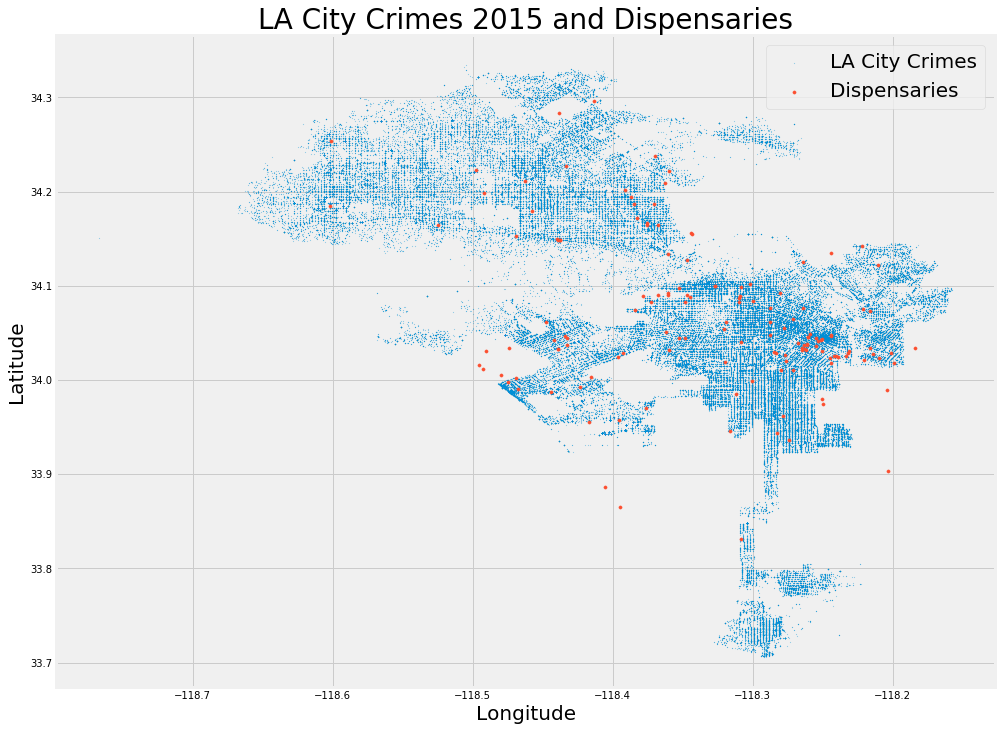

In [44]:
crime_disp_map(crime_2015, df_weed_2, 'LA City Crimes 2015 and Dispensaries')

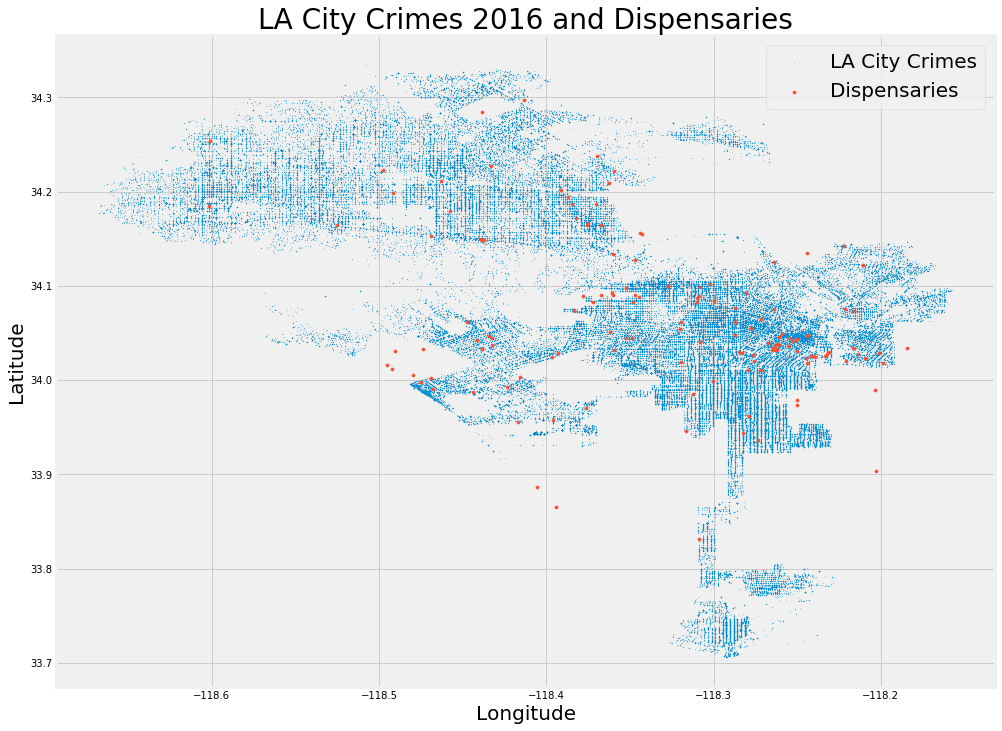

In [45]:
crime_disp_map(crime_2016, df_weed_2, 'LA City Crimes 2016 and Dispensaries')

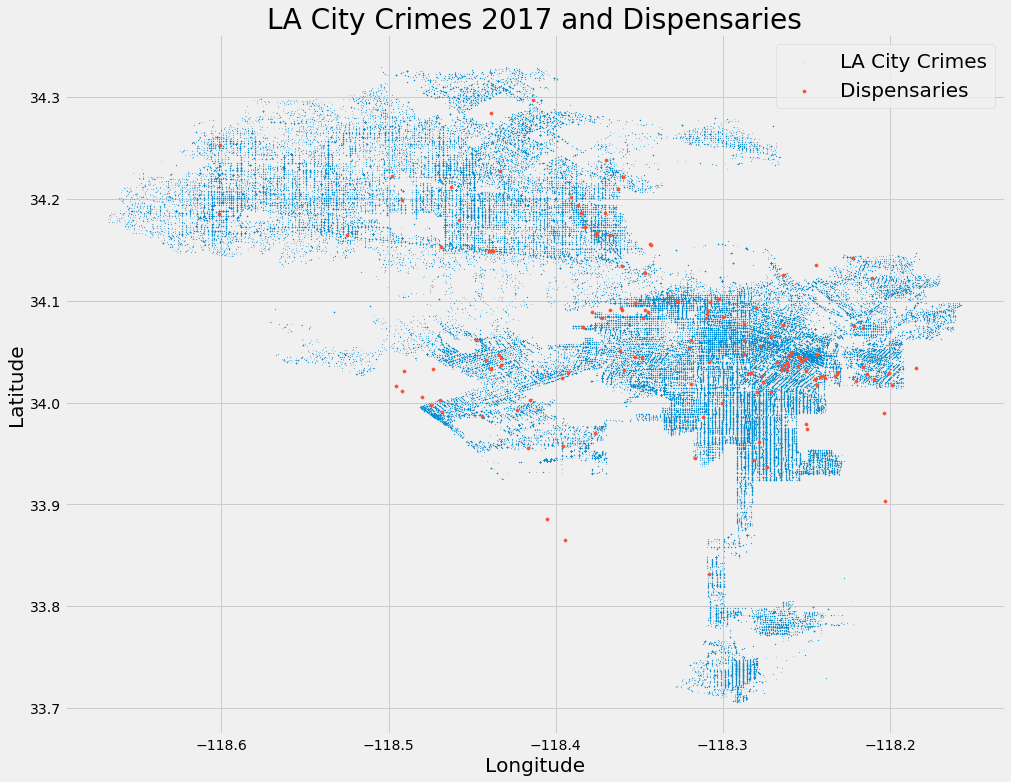

In [220]:
crime_disp_map(crime_2017, df_weed_2, 'LA City Crimes 2017 and Dispensaries')

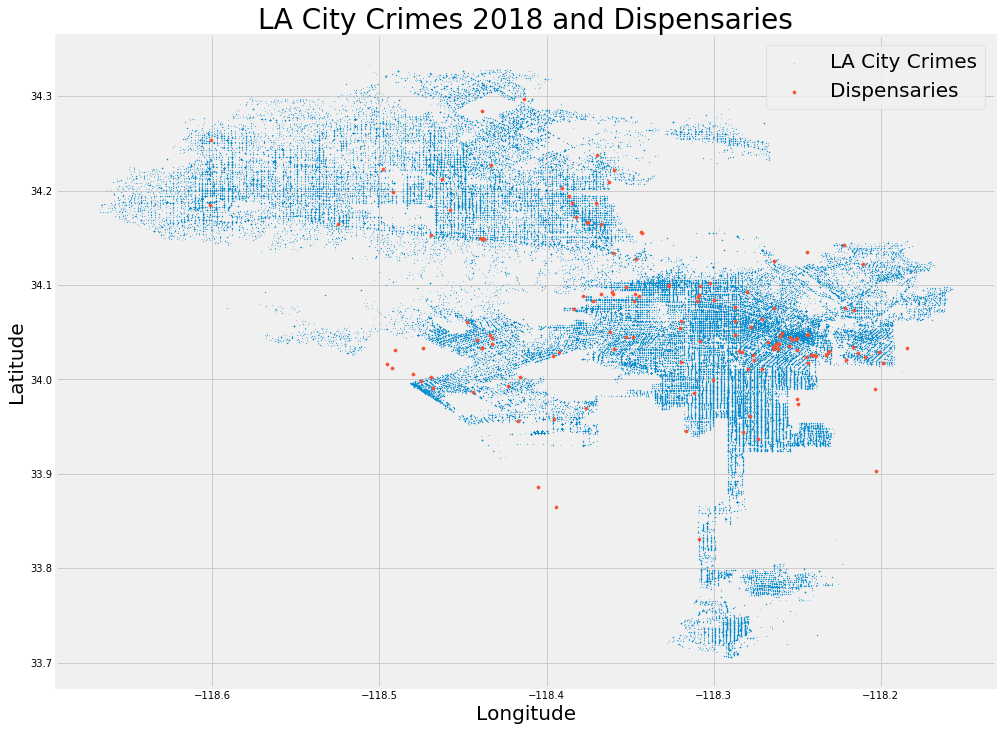

In [46]:
crime_disp_map(crime_2018, df_weed_2, 'LA City Crimes 2018 and Dispensaries')

The above graphs each display the crimes from a given year mapped out in Los Angeles, along with the dispensaries mapped out in orange. While they are cool graphs to look at, they aren't very informative, other than showing that the crime count over a year basically maps out the entire city of LA. There is one thing to note, though. The more populous areas of the city have more crimes, and are therefore more densely represented by the blue dots. 

In [47]:
crime_2015.head()

,area_name,crime_code_description,weapon_description,lat,long,count
date_occurred,,,,,,
2015-01-01,N Hollywood,BURGLARY,unknown,34.1608,-118.3774,1
2015-01-01,Rampart,CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 ...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0398,-118.2780,1
2015-01-01,Newton,THEFT OF IDENTITY,unknown,33.9975,-118.2478,1
2015-01-01,Hollywood,BATTERY ON A FIREFIGHTER,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.1016,-118.3361,1
2015-01-01,Wilshire,THEFT OF IDENTITY,unknown,34.0440,-118.3586,1


Examining some lat, long coordinates. 

In [48]:
df_weed.loc[1, 'latitude']

34.10161

In [49]:
crime_2015.iloc[0]['lat']

34.1608

In [50]:
df_weed.loc[1, 'latitude']

34.10161

In [51]:
df_weed.loc[1, 'longitude']

-118.30206000000001

In [52]:
crime_2015.iloc[1]['lat']

34.0398

In [53]:
crime_2015.iloc[1]['long']

-118.27799999999999

Importing geopy.distance to calculate distances between two coordinates. I borrowed the below code from a stack overflow comment. It's pretty straightforward, though. 

In [54]:
import geopy.distance
def coord_distance(lat1, long1, lat2, long2):
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)

    return geopy.distance.distance(coords_1, coords_2).mi

In [55]:
coord_distance(df_weed.loc[1, 'latitude'], df_weed.loc[1, 'longitude'], crime_2015.iloc[1]['lat'], crime_2015.iloc[1]['long'])

4.478181853422488

Creating random samples of each year's data with 20,000 crimes each, because the original 200,000 + was too much to handle in this scenario. 

In [56]:
crime_2015_sample = crime_2015.sample(20000, random_state = 13)

In [57]:
crime_2016_sample = crime_2016.sample(20000, random_state = 13)

In [58]:
crime_2017_sample = crime_2017.sample(20000, random_state = 13)

In [59]:
crime_2018_sample = crime_2018.sample(20000, random_state = 13)

Creating a function that creates a list of all of the dispensary distances from all the crimes and creates a new column in the dataset reflecting those distances. We will eventually use this data to determine the crime frequency within .5 miles of each dispensary. 

In [60]:
def weed_distance(dispensary, df, loc):
    lst = []
    for i in range(len(df.index)):
        lst.append(coord_distance(df_weed.loc[loc, 'latitude'], 
                           df_weed.loc[loc, 'longitude'], 
                           df.iloc[i]['lat'], 
                           df.iloc[i]['long']))
    df[dispensary] = lst

Testing out the function. 

In [62]:
weed_distance(df_weed.name[0], crime_2015, 0)

In [70]:
for i in range(len(df_weed)):
    weed_distance(df_weed.name[i], crime_2015_sample, i)

In [74]:
crime_2015_sample.to_csv('../data/crime_2015_sample.csv')

In [63]:
crime_2015_sample = pd.read_csv('../data/crime_2015_sample.csv') 

Creating a list of non dispensaries in the dataset so I can ignore them. 

In [95]:
non_disp_list = ['area_name', 'crime_code_description', 'weapon_description',
       'location_', 'date', 'crime_category', 'lat', 'long', 'count', 'date_occurred']

Creating a dispensary list.

In [96]:
disp_list = [col for col in crime_2015_sample.columns if col not in non_disp_list]

In [66]:
crime_2015_sample.head()

,date_occurred,area_name,crime_code_description,weapon_description,location_,date,crime_category,lat,long,count,...,EZ Custom Packaging,Giving Greens Delivery,Purecannastore,Spectwonders,Venice Medical Center,Pasadena 419,Venice Kush,The Blue Diamond Center,101 CBD,Bud Cellar
0,10/31/2015,77th Street,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),unknown,"['33.96', '-118.309']",2015-10-31,Theft,33.9600,-118.3090,1,...,7.052069,3.533849,8.778504,7.242746,6.694498,16.951580,3.638480,13.592168,64.567131,14.643886
1,09/20/2015,Rampart,SHOPLIFTING - PETTY THEFT ($950 & UNDER),unknown,"['34.0554', '-118.2702']",2015-09-20,Theft,34.0554,-118.2702,1,...,1.602235,5.725069,5.153279,11.177134,7.555496,10.757983,5.367745,8.044274,63.585499,9.680812
2,08/20/2015,Pacific,THEFT OF IDENTITY,unknown,"['33.9821', '-118.3612']",2015-08-20,Fraud / Financial Crimes,33.9821,-118.3612,1,...,8.066019,6.418545,10.760352,10.593694,3.540377,17.991837,6.384847,11.973611,61.209418,12.639816
3,05/11/2015,Hollywood,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",unknown,"['34.1107', '-118.3334']",2015-05-11,Theft,34.1107,-118.3334,1,...,6.745173,10.566525,10.067879,16.142548,6.970191,12.501669,10.238672,3.113635,58.768002,4.463323
4,09/03/2015,Rampart,SHOPLIFTING - PETTY THEFT ($950 & UNDER),unknown,"['34.0554', '-118.2702']",2015-09-03,Theft,34.0554,-118.2702,1,...,1.602235,5.725069,5.153279,11.177134,7.555496,10.757983,5.367745,8.044274,63.585499,9.680812


In [67]:
crime_2015_sample.shape

(20000, 171)

Examining using masks to see how many crimes in our 8% sample are within .5 of a mile of a dispensary.

In [68]:
crime_2015_sample[crime_2015_sample['Extra Special Delivery'] < .5]['crime_code_description'].value_counts()

BURGLARY FROM VEHICLE                                       15
INTIMATE PARTNER - SIMPLE ASSAULT                            9
THEFT PLAIN - PETTY ($950 & UNDER)                           8
BATTERY - SIMPLE ASSAULT                                     7
THEFT OF IDENTITY                                            7
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      6
VEHICLE - STOLEN                                             5
ROBBERY                                                      5
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     4
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               4
BURGLARY                                                     4
THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)             4
TRESPASSING                                                  4
CONTEMPT OF COURT                                            3
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                   3
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)        

In [79]:
for i in range(len(df_weed)):
    weed_distance(df_weed.name[i], crime_2016_sample, i)

In [84]:
crime_2016_sample.to_csv('../data/crime_2016_sample.csv')

In [69]:
crime_2016_sample = pd.read_csv('../data/crime_2016_sample.csv')

In [161]:
crime_2016_sample.shape

(20000, 171)

In [70]:
crime_2016_sample[crime_2016_sample['Extra Special Delivery'] <.5]['crime_code_description'].value_counts()

BURGLARY FROM VEHICLE                                       19
THEFT PLAIN - PETTY ($950 & UNDER)                          13
BATTERY - SIMPLE ASSAULT                                     7
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              7
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               6
BURGLARY                                                     5
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     5
INTIMATE PARTNER - SIMPLE ASSAULT                            4
VEHICLE - STOLEN                                             4
LETTERS, LEWD  -  TELEPHONE CALLS, LEWD                      3
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     3
THEFT OF IDENTITY                                            3
TRESPASSING                                                  3
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      3
CONTEMPT OF COURT                                            2
BIKE - STOLEN                                          

In [81]:
for i in range(len(df_weed)):
    weed_distance(df_weed.name[i], crime_2017_sample, i)

In [73]:
crime_2017_sample.shape

(20000, 171)

In [83]:
crime_2017_sample.to_csv('../data/crime_2017_sample.csv')

In [72]:
crime_2017_sample = pd.read_csv('../data/crime_2017_sample.csv')

In [74]:
crime_2017_sample[crime_2017_sample['Extra Special Delivery'] <.5]['crime_code_description'].value_counts()

BATTERY - SIMPLE ASSAULT                                    13
BURGLARY FROM VEHICLE                                       10
THEFT PLAIN - PETTY ($950 & UNDER)                           9
THEFT OF IDENTITY                                            9
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      8
VEHICLE - STOLEN                                             7
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              7
BURGLARY                                                     6
INTIMATE PARTNER - SIMPLE ASSAULT                            6
BIKE - STOLEN                                                5
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     5
BATTERY WITH SEXUAL CONTACT                                  4
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                     4
ROBBERY                                                      3
TRESPASSING                                                  3
DOCUMENT FORGERY / STOLEN FELONY                       

In [86]:
for i in range(len(df_weed)):
    weed_distance(df_weed.name[i], crime_2018_sample, i)

In [77]:
crime_2018_sample.shape

(20000, 171)

In [88]:
crime_2018_sample.to_csv('../data/crime_2018_sample.csv')

In [76]:
crime_2018_sample = pd.read_csv('../data/crime_2018_sample.csv')

Taking a look at the most frequent crimes in 2018. 

In [78]:
crime_2018_sample['crime_code_description'].value_counts().head(10)

BATTERY - SIMPLE ASSAULT                                   1707
BURGLARY FROM VEHICLE                                      1598
VEHICLE - STOLEN                                           1541
THEFT PLAIN - PETTY ($950 & UNDER)                         1407
BURGLARY                                                   1348
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    1119
INTIMATE PARTNER - SIMPLE ASSAULT                          1026
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              940
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             928
THEFT OF IDENTITY                                           923
Name: crime_code_description, dtype: int64

Setting the date as the index and plotting all of the crimes within a halfmile radius of each dispensary. 

In [176]:
#crime_2015_sample.set_index('date_occurred', inplace = True)

Creating a long ugly function with conditionals for each dispensary that allows me to pick a dataframe, a distance, and a title to map out crimes within a certain distance of each dispensary. 

In [80]:
def half_mile_crime(df, dist, title, filename = None): 
    fig, ax = plt.subplots(figsize =(15,12))
    plt.scatter(df[(df['Extra Special Delivery'] < dist) |
    (df['Ganjarunner'] < dist) |
    (df['The Higher Path'] < dist) |
    (df['Kushfly'] < dist) |
    (df['MedMen West Hollywood'] < dist) |
    (df['Green Earth Collective'] < dist) |
    (df['HERB'] < dist) |
    (df['Organic Kind'] < dist) |
    (df['MedMen Downtown - DTLA'] < dist) |
    (df['MedMen Abbot Kinney'] < dist) |
    (df['Mecca Natural Medicine'] < dist) |
    (df['Pot Valet'] < dist) |
    (df['Top Shelf Delivery'] < dist) |
    (df['FireHaus Marijuana Dispensary'] < dist) |
    (df['Cornerstone Research Collective'] < dist) |
    (df['Fast & Friendly Delivery Service'] < dist) |
    (df['Universal Collective'] < dist) |
    (df['Sunset Herbal Corner Dispensary'] < dist) |
    (df['Green Angel'] < dist) |
    (df['Rose Collective'] < dist) |
    (df['Herbarium'] < dist) |
    (df['Los Angeles Patients & Caregivers Group'] < dist) |
    (df['The Healing Touch'] < dist) |
    (df['Green Door West Delivery'] < dist) |
    (df['Alternative Herbal Health Services'] < dist) |
    (df['Exhalence LA'] < dist) |
    (df['The Buddha Company'] < dist) |
    (df['Western Caregivers / California Cannabis Melrose'] < dist) |
    (df['Pineapple Express Delivery'] < dist) |
    (df['Luvbrite Delivery'] < dist) |
    (df['Nugg'] < dist) |
    (df['California Alternative Caregivers'] < dist) |
    (df['MedMen LAX'] < dist) |
    (df['Green Valley Collective'] < dist) |
    (df['MedMen Beverly Hills'] < dist) |
    (df['Best Buds LA'] < dist) |
    (df['420 Caregiver Sherman Oaks Dispensary'] < dist) |
    (df['Los Angeles Kush'] < dist) |
    (df['Cannary West'] < dist) |
    (df['Treetop LA'] < dist) |
    (df['TLC Collective'] < dist) |
    (df['Apothecary420'] < dist) |
    (df['LA Wonderland Marijuana Dispensary Recreational'] < dist) |
    (df['LA Meds 4 Less'] < dist) |
    (df['The Farmacy Westwood'] < dist) |
    (df['Green Cross of Torrance'] < dist) |
    (df['MOTA Medicine Of The Angels'] < dist) |
    (df['The Green Earth Farmacie'] < dist) |
    (df['The Reefinery'] < dist) |
    (df['Clones On Fire'] < dist) |
    (df['New Age Care Center'] < dist) |
    (df['New Amsterdam Naturals - NNCC'] < dist) |
    (df['Compassion Union'] < dist) |
    (df['The Balloon Room'] < dist) |
    (df['Limited Edition420'] < dist) |
    (df['Kush Alley'] < dist) |
    (df['LB Collective'] < dist) |
    (df['LA Cannabis Co - Inglewood'] < dist) |
    (df['Happy Leaf Collective'] < dist) |
    (df['GREENWOLF LA'] < dist) |
    (df['Lit Co'] < dist) |
    (df['Cannajuana Releaf'] < dist) |
    (df['Herbal Nature'] < dist) |
    (df['Fountain Of Wellbeing'] < dist) |
    (df['Shivas Dtla'] < dist) |
    (df['The Pottery'] < dist) |
    (df['Natural Remedies Caregivers'] < dist) |
    (df['Westside Organic Delivery'] < dist) |
    (df['LA Cannabis Co - Los Angeles'] < dist) |
    (df['The Green Rose'] < dist) |
    (df['Connected Cannabis'] < dist) |
    (df['Hollywood Holistic'] < dist) |
    (df['Cali RX'] < dist) |
    (df['The Garden Secrets'] < dist) |
    (df['MK Wellness'] < dist) |
    (df['Sun Valley Caregivers'] < dist) |
    (df['Hollyweed'] < dist) |
    (df['Smartweed'] < dist) |
    (df['Arts District Cannabis Collective'] < dist) |
    (df['BeKind Meds'] < dist) |
    (df['Canna Cabana 420'] < dist) |
    (df['Downtown Natural Caregivers'] < dist) |
    (df['Kushy Delivery'] < dist) |
    (df['BMAC'] < dist) |
    (df['Project Cannabis'] < dist) |
    (df['Trippy Mellow'] < dist) |
    (df['LaLa Land Collective'] < dist) |
    (df['Deals On Wheels'] < dist) |
    (df['Korner Town'] < dist) |
    (df['Kushology'] < dist) |
    (df['Mai Collective'] < dist) |
    (df['2HIGH2DIE'] < dist) |
    (df['Kaz Collective'] < dist) |
    (df['Downtown Patient Group - DTPG'] < dist) |
    (df['Health Stop'] < dist) |
    (df['Enjoyable CBD'] < dist) |
    (df['Cookies Melrose'] < dist) |
    (df['Kushland'] < dist) |
    (df['Semilla_HRC'] < dist) |
    (df['Original Green Bear'] < dist) |
    (df['MedEX'] < dist) |
    (df['Cali Releaf Church of Mien Tao'] < dist) |
    (df['420 Health Care Deliveries'] < dist) |
    (df['Gas Stop'] < dist) |
    (df['ThirdEye Wellness'] < dist) |
    (df['Metro Green Meds'] < dist) |
    (df['Leaf and Lion'] < dist) |
    (df['Best of Buddha Whittier'] < dist) |
    (df['Metro Bloomin'] < dist) |
    (df['Mind Kontrol Delivery Service'] < dist) |
    (df['DTLA Garden'] < dist) |
    (df['Vapeur Terp'] < dist) |
    (df['OG Bros'] < dist) |
    (df['The Cannabis Method'] < dist) |
    (df['Lords Room'] < dist) |
    (df['Mai Fire Buds1 420 MMJ Cannabis Marijuana Delivery'] < dist) |
    (df['24 7 Marijuana Delivery'] < dist) |
    (df['Nothing But Fire 24/7'] < dist) |
    (df['831 Organiks'] < dist) |
    (df['Long Beach Wellness Center'] < dist) |
    (df['SFV Delivers'] < dist) |
    (df['The Green Dot'] < dist) |
    (df['UNIVERSITY 20 CAP'] < dist) |
    (df['The House Of Ounces'] < dist) |
    (df['Nugmen Cannabis Delivery'] < dist) |
    (df['The Circle'] < dist) |
    (df['420 Frat House'] < dist) |
    (df['Cookies Los Angeles'] < dist) |
    (df['West Coast Clones'] < dist) |
    (df['From The Earth'] < dist) |
    (df['Stoney Cannabis Delivery'] < dist) |
    (df['420 Nature Aid'] < dist) |
    (df['Harvest Moon Dispensables'] < dist) |
    (df['CHC 7G 8th'] < dist) |
    (df['LA Discount Super Store'] < dist) |
    (df['Jack Canna'] < dist) |
    (df['420 Ganja Delivery'] < dist) |
    (df['Green Mile'] < dist) |
    (df['420Weedkeef'] < dist) |
    (df['UBER WEED'] < dist) |
    (df['Blowing Trees'] < dist) |
    (df['Downtown Buyers Club'] < dist) |
    (df["Nursery's Best MMJ Delivery"] < dist) |
    (df['Greenberry Collective'] < dist) |
    (df['HerbanMed Delivery'] < dist) |
    (df['High Flyers CA'] < dist) |
    (df['Five Star Collective'] < dist) |
    (df['NoHiCBD'] < dist) |
    (df['Vybes'] < dist) |
    (df['High Maintenance LA'] < dist) |
    (df['Marijuana Strains Store'] < dist) |
    (df['EZ Custom Packaging'] < dist) |
    (df['Giving Greens Delivery'] < dist) |
    (df['Purecannastore'] < dist) |
    (df['Spectwonders'] < dist) |
    (df['Venice Medical Center'] < dist) |
    (df['Pasadena 419'] < dist) |
    (df['Venice Kush'] < dist) |
    (df['The Blue Diamond Center'] < dist) |
    (df['101 CBD'] < dist) |
    (df['Bud Cellar'] < dist)]['long'],
    df[(df['Extra Special Delivery'] < dist) |
    (df['Ganjarunner'] < dist) |
    (df['The Higher Path'] < dist) |
    (df['Kushfly'] < dist) |
    (df['MedMen West Hollywood'] < dist) |
    (df['Green Earth Collective'] < dist) |
    (df['HERB'] < dist) |
    (df['Organic Kind'] < dist) |
    (df['MedMen Downtown - DTLA'] < dist) |
    (df['MedMen Abbot Kinney'] < dist) |
    (df['Mecca Natural Medicine'] < dist) |
    (df['Pot Valet'] < dist) |
    (df['Top Shelf Delivery'] < dist) |
    (df['FireHaus Marijuana Dispensary'] < dist) |
    (df['Cornerstone Research Collective'] < dist) |
    (df['Fast & Friendly Delivery Service'] < dist) |
    (df['Universal Collective'] < dist) |
    (df['Sunset Herbal Corner Dispensary'] < dist) |
    (df['Green Angel'] < dist) |
    (df['Rose Collective'] < dist) |
    (df['Herbarium'] < dist) |
    (df['Los Angeles Patients & Caregivers Group'] < dist) |
    (df['The Healing Touch'] < dist) |
    (df['Green Door West Delivery'] < dist) |
    (df['Alternative Herbal Health Services'] < dist) |
    (df['Exhalence LA'] < dist) |
    (df['The Buddha Company'] < dist) |
    (df['Western Caregivers / California Cannabis Melrose'] < dist) |
    (df['Pineapple Express Delivery'] < dist) |
    (df['Luvbrite Delivery'] < dist) |
    (df['Nugg'] < dist) |
    (df['California Alternative Caregivers'] < dist) |
    (df['MedMen LAX'] < dist) |
    (df['Green Valley Collective'] < dist) |
    (df['MedMen Beverly Hills'] < dist) |
    (df['Best Buds LA'] < dist) |
    (df['420 Caregiver Sherman Oaks Dispensary'] < dist) |
    (df['Los Angeles Kush'] < dist) |
    (df['Cannary West'] < dist) |
    (df['Treetop LA'] < dist) |
    (df['TLC Collective'] < dist) |
    (df['Apothecary420'] < dist) |
    (df['LA Wonderland Marijuana Dispensary Recreational'] < dist) |
    (df['LA Meds 4 Less'] < dist) |
    (df['The Farmacy Westwood'] < dist) |
    (df['Green Cross of Torrance'] < dist) |
    (df['MOTA Medicine Of The Angels'] < dist) |
    (df['The Green Earth Farmacie'] < dist) |
    (df['The Reefinery'] < dist) |
    (df['Clones On Fire'] < dist) |
    (df['New Age Care Center'] < dist) |
    (df['New Amsterdam Naturals - NNCC'] < dist) |
    (df['Compassion Union'] < dist) |
    (df['The Balloon Room'] < dist) |
    (df['Limited Edition420'] < dist) |
    (df['Kush Alley'] < dist) |
    (df['LB Collective'] < dist) |
    (df['LA Cannabis Co - Inglewood'] < dist) |
    (df['Happy Leaf Collective'] < dist) |
    (df['GREENWOLF LA'] < dist) |
    (df['Lit Co'] < dist) |
    (df['Cannajuana Releaf'] < dist) |
    (df['Herbal Nature'] < dist) |
    (df['Fountain Of Wellbeing'] < dist) |
    (df['Shivas Dtla'] < dist) |
    (df['The Pottery'] < dist) |
    (df['Natural Remedies Caregivers'] < dist) |
    (df['Westside Organic Delivery'] < dist) |
    (df['LA Cannabis Co - Los Angeles'] < dist) |
    (df['The Green Rose'] < dist) |
    (df['Connected Cannabis'] < dist) |
    (df['Hollywood Holistic'] < dist) |
    (df['Cali RX'] < dist) |
    (df['The Garden Secrets'] < dist) |
    (df['MK Wellness'] < dist) |
    (df['Sun Valley Caregivers'] < dist) |
    (df['Hollyweed'] < dist) |
    (df['Smartweed'] < dist) |
    (df['Arts District Cannabis Collective'] < dist) |
    (df['BeKind Meds'] < dist) |
    (df['Canna Cabana 420'] < dist) |
    (df['Downtown Natural Caregivers'] < dist) |
    (df['Kushy Delivery'] < dist) |
    (df['BMAC'] < dist) |
    (df['Project Cannabis'] < dist) |
    (df['Trippy Mellow'] < dist) |
    (df['LaLa Land Collective'] < dist) |
    (df['Deals On Wheels'] < dist) |
    (df['Korner Town'] < dist) |
    (df['Kushology'] < dist) |
    (df['Mai Collective'] < dist) |
    (df['2HIGH2DIE'] < dist) |
    (df['Kaz Collective'] < dist) |
    (df['Downtown Patient Group - DTPG'] < dist) |
    (df['Health Stop'] < dist) |
    (df['Enjoyable CBD'] < dist) |
    (df['Cookies Melrose'] < dist) |
    (df['Kushland'] < dist) |
    (df['Semilla_HRC'] < dist) |
    (df['Original Green Bear'] < dist) |
    (df['MedEX'] < dist) |
    (df['Cali Releaf Church of Mien Tao'] < dist) |
    (df['420 Health Care Deliveries'] < dist) |
    (df['Gas Stop'] < dist) |
    (df['ThirdEye Wellness'] < dist) |
    (df['Metro Green Meds'] < dist) |
    (df['Leaf and Lion'] < dist) |
    (df['Best of Buddha Whittier'] < dist) |
    (df['Metro Bloomin'] < dist) |
    (df['Mind Kontrol Delivery Service'] < dist) |
    (df['DTLA Garden'] < dist) |
    (df['Vapeur Terp'] < dist) |
    (df['OG Bros'] < dist) |
    (df['The Cannabis Method'] < dist) |
    (df['Lords Room'] < dist) |
    (df['Mai Fire Buds1 420 MMJ Cannabis Marijuana Delivery'] < dist) |
    (df['24 7 Marijuana Delivery'] < dist) |
    (df['Nothing But Fire 24/7'] < dist) |
    (df['831 Organiks'] < dist) |
    (df['Long Beach Wellness Center'] < dist) |
    (df['SFV Delivers'] < dist) |
    (df['The Green Dot'] < dist) |
    (df['UNIVERSITY 20 CAP'] < dist) |
    (df['The House Of Ounces'] < dist) |
    (df['Nugmen Cannabis Delivery'] < dist) |
    (df['The Circle'] < dist) |
    (df['420 Frat House'] < dist) |
    (df['Cookies Los Angeles'] < dist) |
    (df['West Coast Clones'] < dist) |
    (df['From The Earth'] < dist) |
    (df['Stoney Cannabis Delivery'] < dist) |
    (df['420 Nature Aid'] < dist) |
    (df['Harvest Moon Dispensables'] < dist) |
    (df['CHC 7G 8th'] < dist) |
    (df['LA Discount Super Store'] < dist) |
    (df['Jack Canna'] < dist) |
    (df['420 Ganja Delivery'] < dist) |
    (df['Green Mile'] < dist) |
    (df['420Weedkeef'] < dist) |
    (df['UBER WEED'] < dist) |
    (df['Blowing Trees'] < dist) |
    (df['Downtown Buyers Club'] < dist) |
    (df["Nursery's Best MMJ Delivery"] < dist) |
    (df['Greenberry Collective'] < dist) |
    (df['HerbanMed Delivery'] < dist) |
    (df['High Flyers CA'] < dist) |
    (df['Five Star Collective'] < dist) |
    (df['NoHiCBD'] < dist) |
    (df['Vybes'] < dist) |
    (df['High Maintenance LA'] < dist) |
    (df['Marijuana Strains Store'] < dist) |
    (df['EZ Custom Packaging'] < dist) |
    (df['Giving Greens Delivery'] < dist) |
    (df['Purecannastore'] < dist) |
    (df['Spectwonders'] < dist) |
    (df['Venice Medical Center'] < dist) |
    (df['Pasadena 419'] < dist) |
    (df['Venice Kush'] < dist) |
    (df['The Blue Diamond Center'] < dist) |
    (df['101 CBD'] < dist) |
    (df['Bud Cellar'] < dist)]['lat'], 
                 color='C0', label='LA City Crimes', s = 5, alpha = .5)
    ax.scatter(df_weed_2['longitude'], df_weed_2['latitude'], color='C1', label='Dispensaries', s = 20)
    plt.title(title, fontsize=28)
    plt.xlabel('Longitude', fontsize=20)
    plt.ylabel('Latitude', fontsize=20)
    ax.legend(fontsize=20)
    if filename:
        plt.savefig(f'../plots/{filename}.png');

Below, we will be examining crimes surrounding dispensaries over each year. Because of the density of these crimes, we will not be able to visually see how many crimes are committed within half mile of dispensaries, but we can examine how a change in radius affects the graphs.

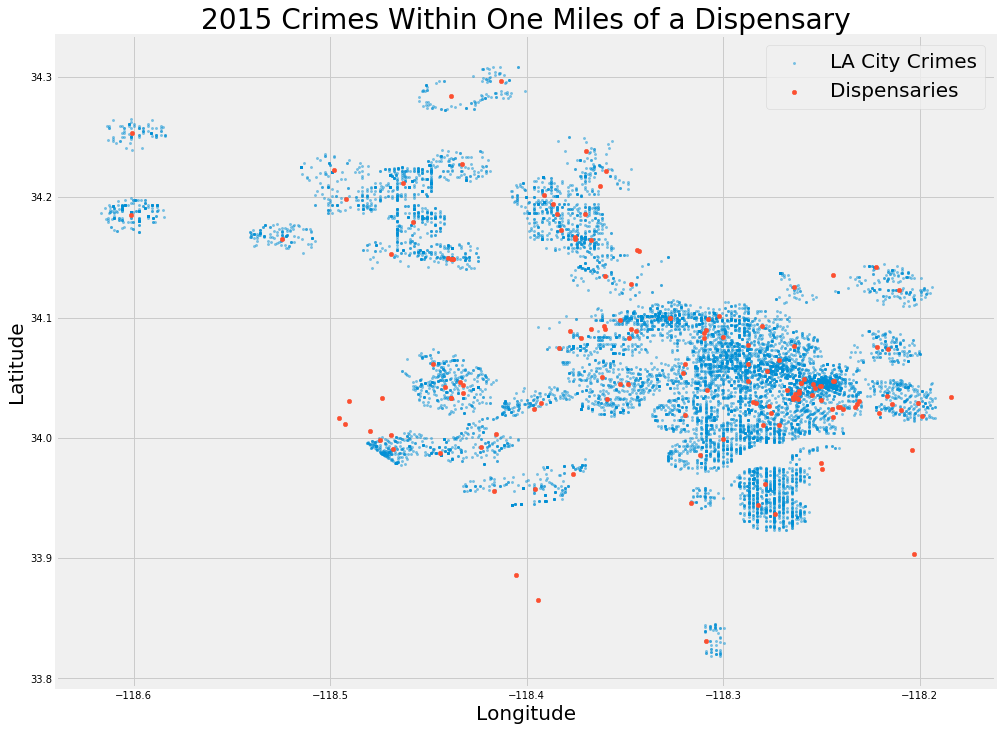

In [81]:
half_mile_crime(crime_2015_sample, 1, '2015 Crimes Within One Miles of a Dispensary')

Above, we are looking at a 1 mile radius surrounding each dispensary. This is an unrealistic distance, as it includes most of the city. Crime surrounding dispensaries within 1 mile shouldn't be affected by legalization. A mile is a pretty big radius for crime. We will examine smaller radii next.

Below, we will examine a 3/4 mile radius surrounding dispensaries in 2016.

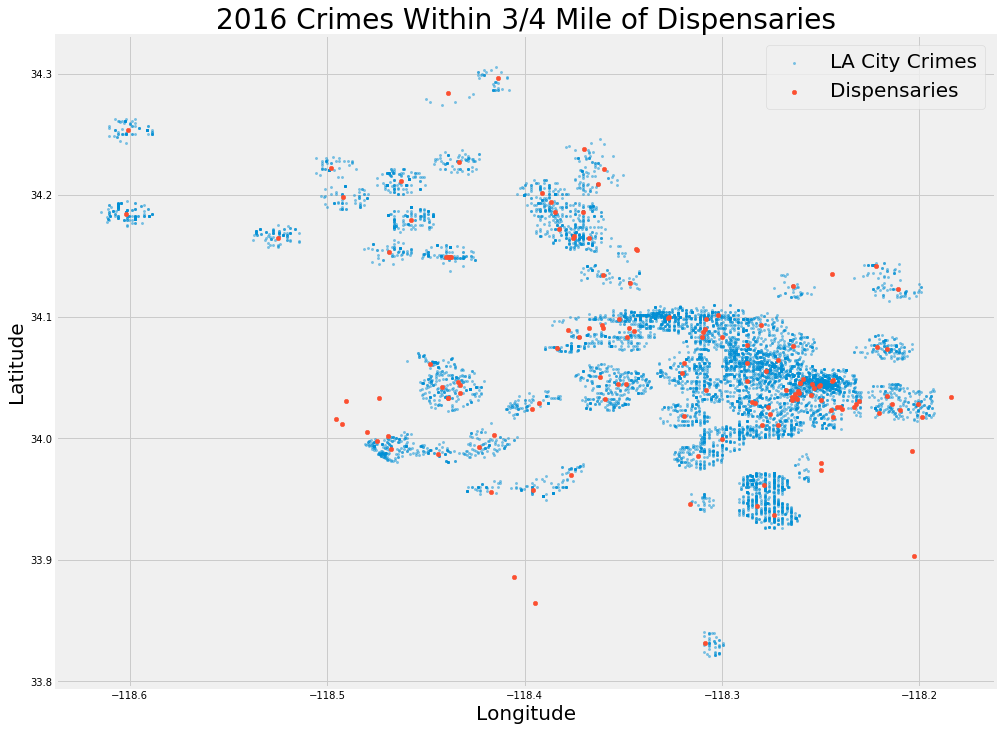

In [82]:
half_mile_crime(crime_2016_sample, .75, '2016 Crimes Within 3/4 Mile of Dispensaries')

As we can see, compared to the full mile, our crimes surrounding the dispensaries have decreased. We still have a heavy focus in the more metropolitan area of los angeles, which is expected, since there is a higher concentration of both people and dispensaries. We can see that the crimes are still forming pretty big clusters, with basically all of the eastern side of LA as one cluster. We think .75 is still too big of a radius for determining the effect of legalization on crime rates surrounding dispensaries.

Below, we will examine a half mile radius around dispensaries for crimes in 2017.

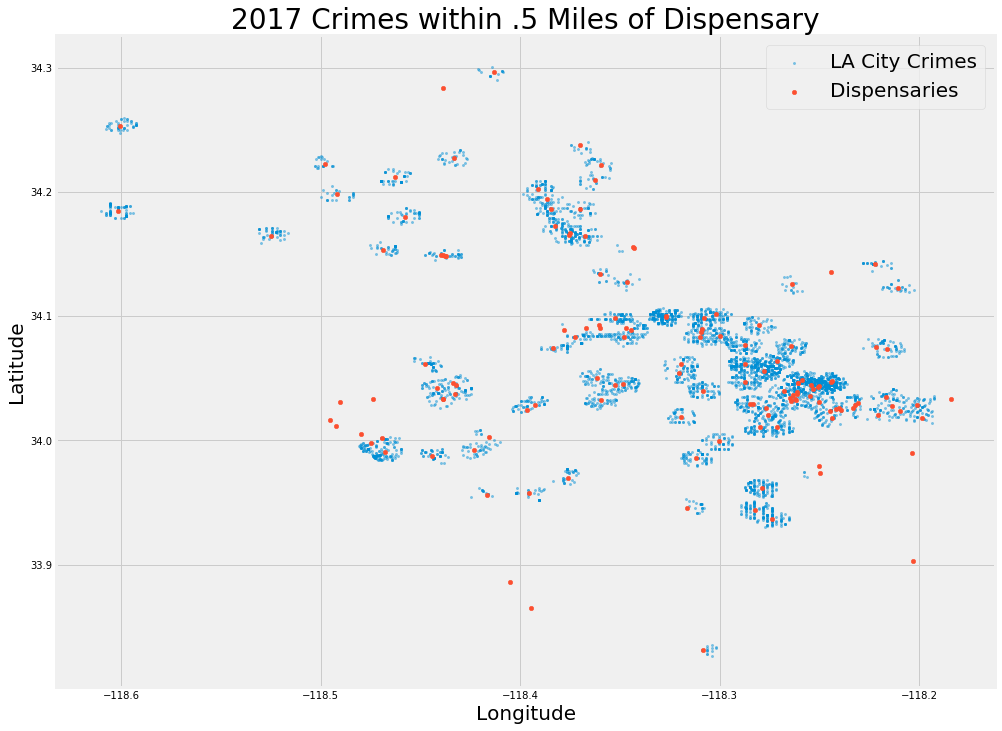

In [83]:
half_mile_crime(crime_2017_sample, .5, '2017 Crimes within .5 Miles of Dispensary', 'crime_2017')

As we can see above, the crimes are starting to form smaller and more individual clusters around dispensaries on the eastern side of LA. This will likely be our go-to radius for our ARIMA model. 

Below we will examine a quarter mile radius surrounding dispensaries.

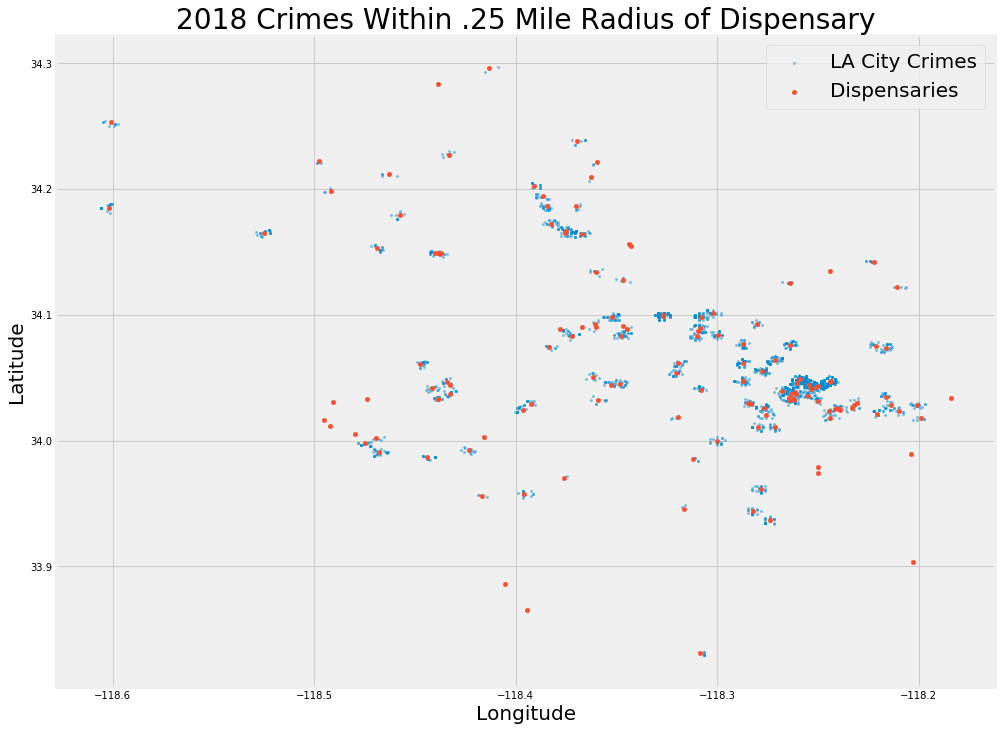

In [84]:
half_mile_crime(crime_2018_sample, .25, '2018 Crimes Within .25 Mile Radius of Dispensary')

Except for in a few areas, the dispensaries basically have formed their own clusters. In the dense part of eastern LA, there is still some bigger clustering, but we can see that there is higher concentration of dispensaries over there. 

In [85]:
crime_2015_sample.reset_index(inplace = True)
crime_2016_sample.reset_index(inplace = True)
crime_2017_sample.reset_index(inplace = True)
crime_2018_sample.reset_index(inplace = True)

In [86]:
crime_2015_sample.head()

,index,date_occurred,area_name,crime_code_description,weapon_description,location_,date,crime_category,lat,long,...,EZ Custom Packaging,Giving Greens Delivery,Purecannastore,Spectwonders,Venice Medical Center,Pasadena 419,Venice Kush,The Blue Diamond Center,101 CBD,Bud Cellar
0,0,10/31/2015,77th Street,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),unknown,"['33.96', '-118.309']",2015-10-31,Theft,33.9600,-118.3090,...,7.052069,3.533849,8.778504,7.242746,6.694498,16.951580,3.638480,13.592168,64.567131,14.643886
1,1,09/20/2015,Rampart,SHOPLIFTING - PETTY THEFT ($950 & UNDER),unknown,"['34.0554', '-118.2702']",2015-09-20,Theft,34.0554,-118.2702,...,1.602235,5.725069,5.153279,11.177134,7.555496,10.757983,5.367745,8.044274,63.585499,9.680812
2,2,08/20/2015,Pacific,THEFT OF IDENTITY,unknown,"['33.9821', '-118.3612']",2015-08-20,Fraud / Financial Crimes,33.9821,-118.3612,...,8.066019,6.418545,10.760352,10.593694,3.540377,17.991837,6.384847,11.973611,61.209418,12.639816
3,3,05/11/2015,Hollywood,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",unknown,"['34.1107', '-118.3334']",2015-05-11,Theft,34.1107,-118.3334,...,6.745173,10.566525,10.067879,16.142548,6.970191,12.501669,10.238672,3.113635,58.768002,4.463323
4,4,09/03/2015,Rampart,SHOPLIFTING - PETTY THEFT ($950 & UNDER),unknown,"['34.0554', '-118.2702']",2015-09-03,Theft,34.0554,-118.2702,...,1.602235,5.725069,5.153279,11.177134,7.555496,10.757983,5.367745,8.044274,63.585499,9.680812


In [87]:
crime_2015_sample.drop('index', axis = 1, inplace = True)
crime_2016_sample.drop('index', axis = 1, inplace = True)
crime_2017_sample.drop('index', axis = 1, inplace = True)
crime_2018_sample.drop('index', axis = 1, inplace = True)

Making a function to set date_occured to a datetime, then it will sort the values, then set the sorted dates as the index. 

In [88]:
def df_to_time_index(df):
    df.date_occurred = pd.to_datetime(df.date_occurred)
    df.sort_values(by = 'date_occurred', inplace= True)
    df.set_index('date_occurred', inplace = True)
    return df

In [89]:
crime_2015_sample = df_to_time_index(crime_2015_sample)

In [90]:
crime_2016_sample = df_to_time_index(crime_2016_sample)

In [91]:
crime_2017_sample = df_to_time_index(crime_2017_sample)

In [92]:
crime_2018_sample = df_to_time_index(crime_2018_sample)

Writing a function to create a 'count' column that shows how many crimes occcured within a certain distance of the dispensaries. We will use this for our ARIMA models. 

In [93]:
def crime_count_by_day(df, dist):    
    crime_count_list = []
    for i in range(len(df)):
        count = 0
        for n in disp_list:
            if df[n].iloc[i] < dist:
                count += 1
        crime_count_list.append(count)  
    df['count'] = crime_count_list    

In [97]:
crime_count_by_day(crime_2015_sample, .5)

In [98]:
crime_count_by_day(crime_2016_sample, .5)

In [99]:
crime_count_by_day(crime_2017_sample, .5)

In [100]:
crime_count_by_day(crime_2018_sample, .5)

Concatenating all of the years crime data into one dataframe so we can run an ARIMA model. 

In [101]:
crime_sample = pd.concat([crime_2015_sample, crime_2016_sample, crime_2017_sample, crime_2018_sample])

In [102]:
crime_sample.shape

(80000, 170)

In [103]:
crime_sample[crime_sample['Extra Special Delivery'] < .5]['crime_code_description'].value_counts()

BURGLARY FROM VEHICLE                                       52
THEFT PLAIN - PETTY ($950 & UNDER)                          45
BATTERY - SIMPLE ASSAULT                                    42
VEHICLE - STOLEN                                            27
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)             26
INTIMATE PARTNER - SIMPLE ASSAULT                           25
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)     25
THEFT OF IDENTITY                                           23
BURGLARY                                                    22
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              16
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                    16
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    14
THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)            12
BIKE - STOLEN                                               12
TRESPASSING                                                 11
ROBBERY                                                

Examining some of the crime code descriptions for the top 5 dispensaries in the list. 

In [104]:
[crime_sample[crime_sample[disp] < .5]['crime_code_description'].value_counts().head() for disp in disp_list][:5]

[BURGLARY FROM VEHICLE                              52
 THEFT PLAIN - PETTY ($950 & UNDER)                 45
 BATTERY - SIMPLE ASSAULT                           42
 VEHICLE - STOLEN                                   27
 THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)    26
 Name: crime_code_description, dtype: int64,
 THEFT PLAIN - PETTY ($950 & UNDER)    52
 BATTERY - SIMPLE ASSAULT              39
 BURGLARY FROM VEHICLE                 34
 VEHICLE - STOLEN                      32
 THEFT OF IDENTITY                     30
 Name: crime_code_description, dtype: int64,
 THEFT OF IDENTITY                                  20
 BURGLARY FROM VEHICLE                              20
 BURGLARY                                           18
 THEFT PLAIN - PETTY ($950 & UNDER)                 13
 THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)    10
 Name: crime_code_description, dtype: int64,
 BURGLARY FROM VEHICLE                                      15
 BURGLARY                                 

Writing a function to plot our crime counts by day, and by rolling averages for 30, 91, and 365 days. 

Examining daily crime counts, 30 day rolling crime counts, quarterly rolling crime counts, and yearly rolling crime counts. 

In [105]:
def rolling_graphs(df, title):
    fig, ax = plt.subplots(figsize =(20,10))
    plt.plot(df.groupby([df.index, 'count']).size().unstack('count')[1],  color = 'C0')
    plt.plot(df.groupby([df.index, 'count']).size().unstack('count')[1].rolling(30).mean(), color = 'C1')
    plt.plot(df.groupby([df.index, 'count']).size().unstack('count')[1].rolling(91).mean(), color = 'C2')
    plt.plot(df.groupby([df.index, 'count']).size().unstack('count')[1].rolling(365).mean(), color = 'purple')

    plt.title(title, fontsize = 35)
    plt.xticks(fontsize = 25, rotation = 20)
    plt.yticks(fontsize = 25)
    plt.ylabel('Crimes Per Day', fontsize = 30)
    plt.legend(['Daily', '30 Day Rolling', '91 Day Rolling', '365 Day Rolling'], fontsize = 15);
    plt.grid(alpha = .4)
    plt.tight_layout()
    plt.savefig(f'../plots/crimes_per_day.png');
    

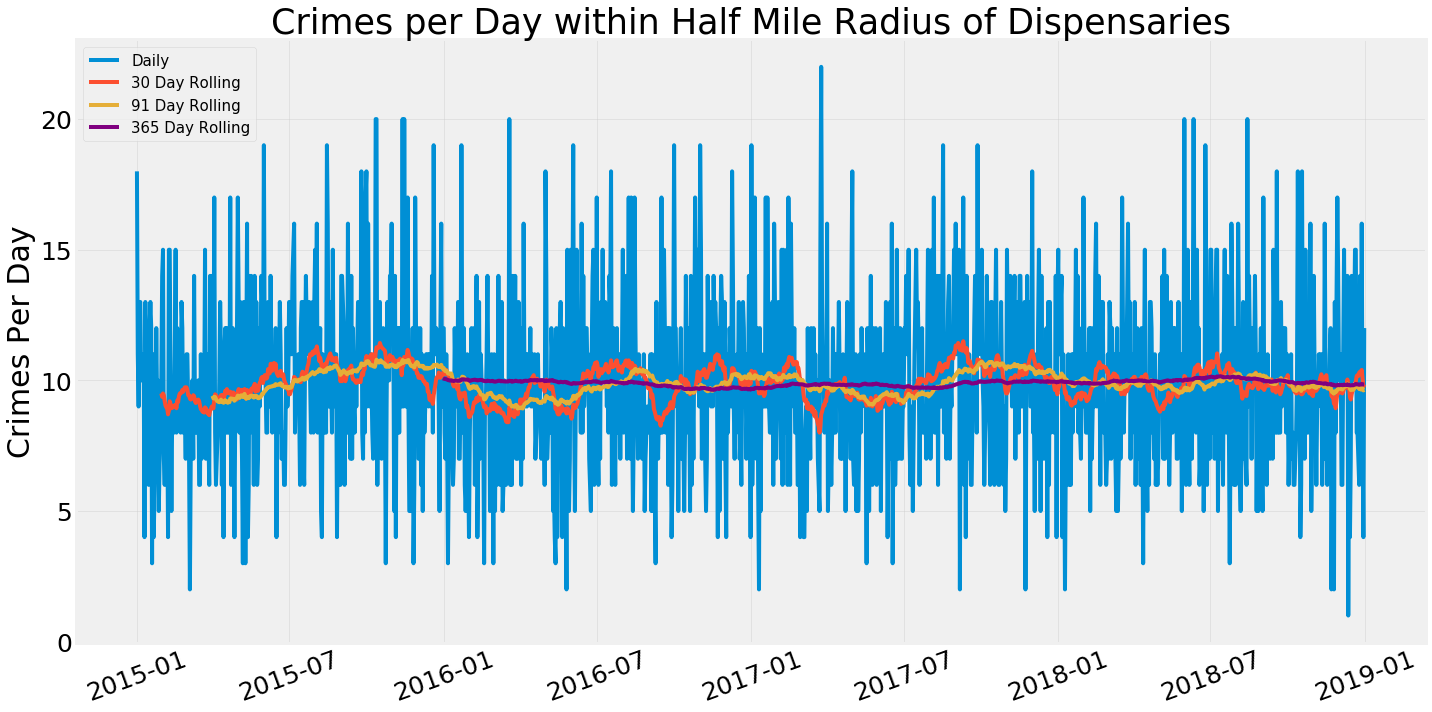

In [106]:
rolling_graphs(crime_sample, 'Crimes per Day within Half Mile Radius of Dispensaries')

Above, the graph displays the daily crime rates from 2015 to the end of 2018 on a sampled dataset from our original crime dataset. As we can see, the daily fluctuations are difficult to read and have a lot of noise, without much signal. Looking at the 30 days rolling average, we can see that there is still some fluctuation in the crime rate, but it generally sticks to the mean crime count. The quarterly crime count flattens out even more, and we can see that once we look at the yearly rolling average, the line is almost a flat line that hovers around the mean of 9.8 crimes per day. 

Creating a dataset that groups by date and totals the number of crimes that happened on that day within half mile radius of a dispensary. Below, we will run an arima model using this dataset. 

In [107]:
crime_arima = crime_sample.groupby([crime_sample.index, 'count']).size().unstack('count')[1]

Also creating a dataset that groups by date based on the 30 day rolling average crime rate. 

In [108]:
crime_arima_month = crime_sample.groupby([crime_sample.index, 'count']).size().unstack('count')[1].rolling(30).mean()

In [109]:
crime_arima_month.shape

(1461,)

In [110]:
crime_arima_month.isnull().sum()

29

In [111]:
crime_arima_month.dropna(inplace = True)

In [112]:
crime_arima_month.shape

(1432,)

In [113]:
crime_arima_month.shape[0] * 3/4

1074.0

Creating a train test split for my crime_arima_month dataset. I am splitting at the 3/4 mark. 

In [114]:
train_month = crime_arima_month.iloc[0:1074]
test_month = crime_arima_month.iloc[1075:]

Fitting and predicting on my AR(1,1) model. 

In [115]:
model = ARIMA(endog = train_month,
              order = (1,0,1))
arima_1_0_0 = model.fit()

preds_train_month = arima_1_0_0.predict(start = 0, end = 1073)
preds_test_month = arima_1_0_0.predict(start = 1074, end = 1430)

In [116]:
print(mean_squared_error(train_month, preds_train_month)**(1/2))
print(mean_squared_error(test_month, preds_test_month)**(1/2))

0.1489946602015425
0.43296143719185237


Looking at the RMSE scores above, we can see that our model predicts pretty well on both the training and the test set. On average, out of the 8 - 11.5 crimes per day on the monthly rolling average, our residuals are off by .14 on average. On the testing data, our predictions are off by .43 on average. 

In [117]:
crime_arima_month.max()

11.5

In [118]:
crime_arima_month.min()

8.0

Plotting our ARIMA model below using the monthly rolling average

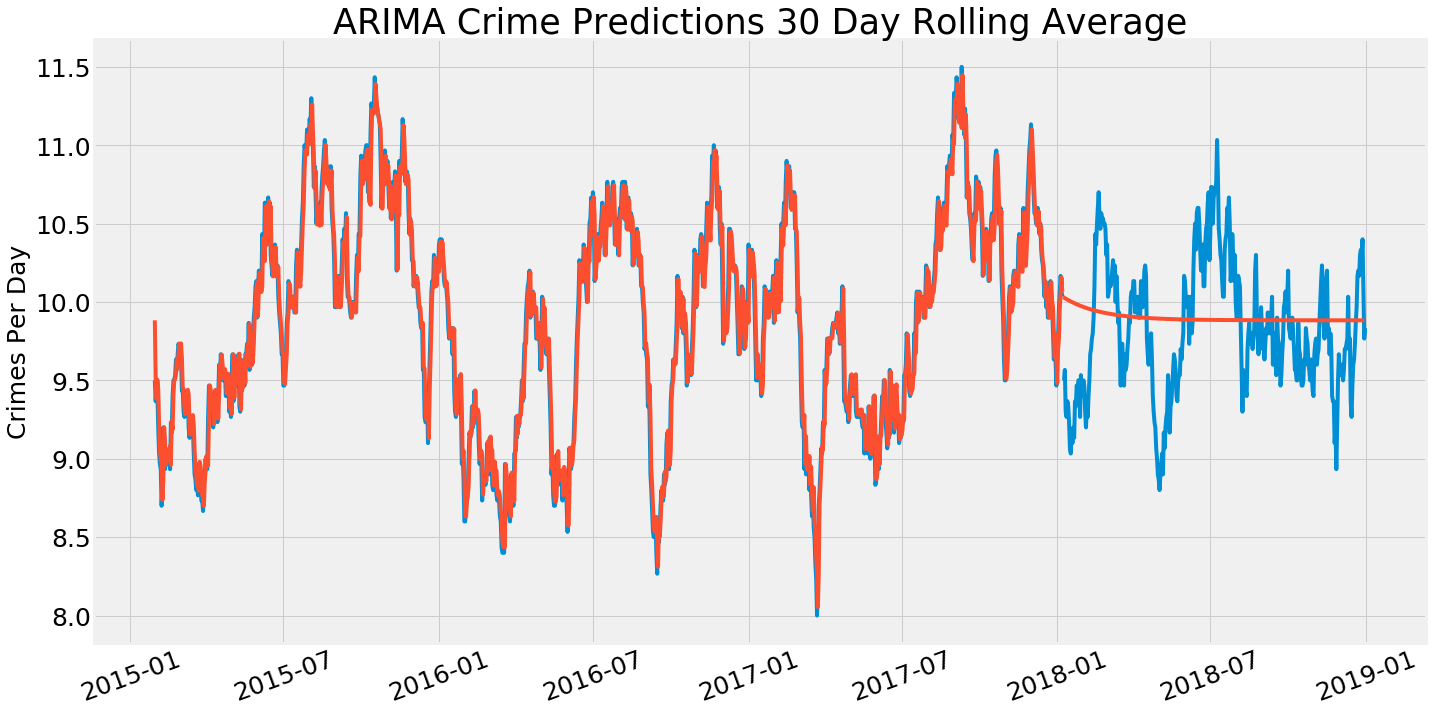

In [119]:
plt.figure(figsize = (20,10))
plt.plot(train_month, color = 'C0')
plt.plot(preds_train_month, color = 'C1')
plt.plot(test_month, color = 'C0')
plt.plot(preds_test_month, color = 'C1')

plt.title('ARIMA Crime Predictions 30 Day Rolling Average', fontsize = 35)
plt.xticks(fontsize = 25, rotation = 20)
plt.yticks(fontsize = 25)
plt.ylabel('Crimes Per Day', fontsize = 25)
plt.tight_layout()
plt.savefig('../plots/arima_2.png');

Looking at the graph above, our training data goes until 2018-01 and our testing data goes from 2018-01 to 2019-01. Our model severely overfits our training set, with almost zero residuals. Our model breaks down right as it starts to predict on the testing data. It almost immediately begins predicting the mean. I think the daily trends aren't consistent enough for the model to make predictions that aren't the 'safe bet', or the baseline. This model helps to show us that predicting the mean isn't a necessarily a bad thing. Crime rates surrounding dispensaries have remained pretty constant over time, which suggests that legalizing weed hasn't had a negative impact on crime surrounding dispensaries. We are predicting that our data is stationary, but we will test for stationarity below just to confirm. 

Using the augmented dickey fuller test to look for stationarity. 

In [120]:
adfuller(crime_arima_month)

(-4.887258750258324,
 3.69215646241794e-05,
 17,
 1414,
 {'1%': -3.4349831053858746,
  '5%': -2.863586191208161,
  '10%': -2.567859382293453},
 -1361.980424644088)

Function for interpretting ADF test. 

In [121]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index = ['Test Statistic', 'p-value'])
    return dfoutput

In [122]:
interpret_dftest(adfuller(crime_arima_month))

Test Statistic   -4.887259
p-value           0.000037
dtype: float64

We can see that the p value score is below .05, so we can accept that our data is stationary. 

Now we are going to try the daily crime rates and see how our model compares to the monthly rolling average. 

In [125]:
crime_arima.shape

(1461,)

In [126]:
crime_arima.shape[0] * 3/4

1095.75

Creating a training and testing set for our crime_arima dataset. This one is based on the daily crime rates, without a rolling average.

In [127]:
train = crime_arima.iloc[0: 1096]
test = crime_arima.iloc[1097:]

Fitting and predicting on my training set for the daily crime rate. 

In [128]:
model = ARIMA(endog = train,
              order = (2,0,1))
arima_1_0_0 = model.fit()

preds_train = arima_1_0_0.predict(start = 0, end = 1095)
preds_test = arima_1_0_0.predict(start = 1096, end = 1459)

In [129]:
mean_squared_error(train, preds_train) ** (1/2)

3.2626730866672187

In [130]:
mean_squared_error(test, preds_test) ** (1/2)

3.280414244423046

Looking at the RMSE, we can see that the model predicts about the same on the training and testing sets, with a RMSE of about 3.3 crimes per day. 

In [131]:
crime_arima.mean()

9.880903490759753

Plotting the daily crime crates and our ARIMA predictions. 

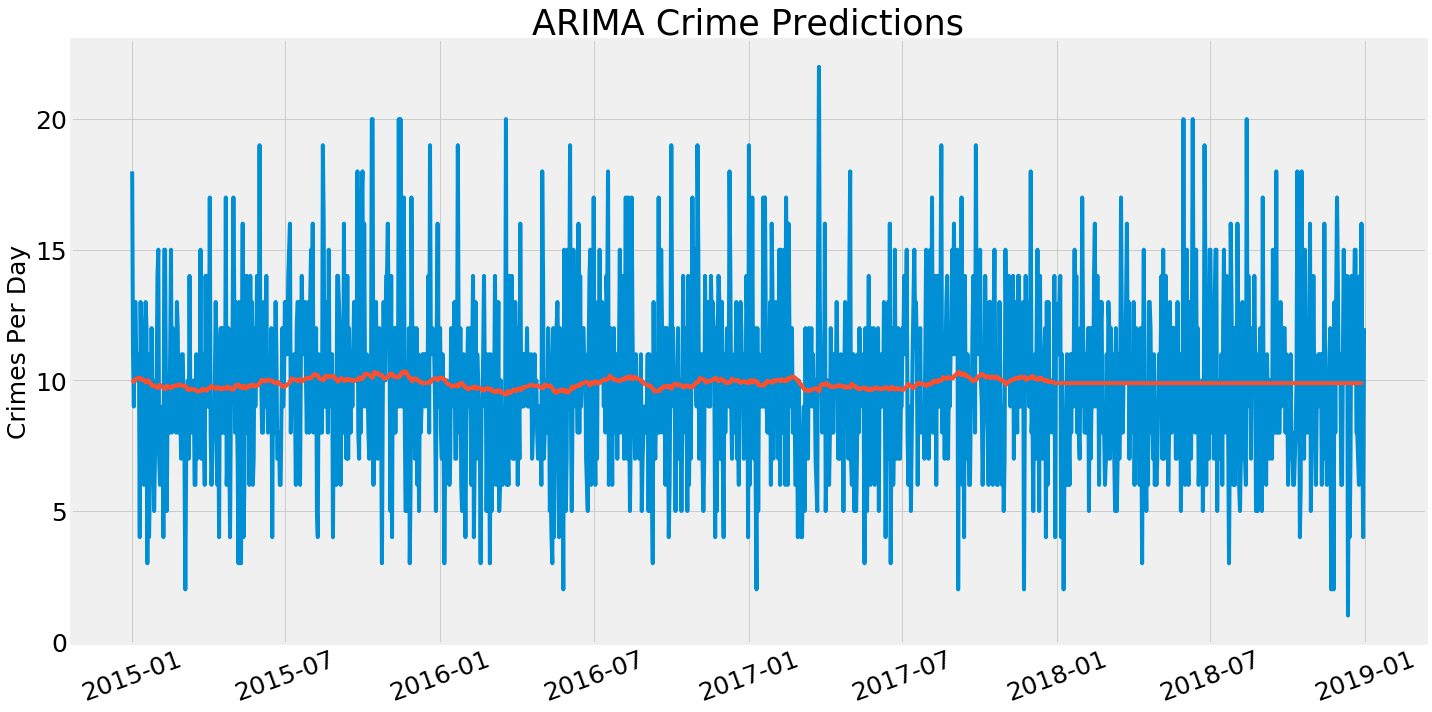

In [132]:
plt.figure(figsize = (20,10))
plt.plot(train)
plt.plot(preds_train)
plt.plot(test, c = 'C0')
plt.plot(preds_test, c = 'C1')

plt.title('ARIMA Crime Predictions', fontsize = 35)
plt.xticks(fontsize = 25, rotation = 20)
plt.yticks(fontsize = 25)
plt.ylabel('Crimes Per Day', fontsize = 25)
plt.tight_layout()
plt.savefig('../plots/arima_1.png');

Looking at the graph above, we can see that our arima model had a difficult time predicting anything other than the mean on the daily crime rates. The data is very noise, with little signal, so our model wasn't able to predict anything that varied from the mean. In our training data, there is the tiniest bit of movement in our predictions, but as soon as the model hits our testing data on 2018-01, our model breaks down and predicts a straight line. 

In [133]:
adfuller(crime_arima)

(-38.20021205287497,
 0.0,
 0,
 1460,
 {'1%': -3.434836872962171,
  '5%': -2.863521656701378,
  '10%': -2.567825016419591},
 7482.8505150861165)

In [134]:
interpret_dftest(adfuller(crime_arima))

Test Statistic   -38.200212
p-value            0.000000
dtype: float64

Again, we can see that our p value is less than .05, so we can accept that our model is stationary. 

## Conclusion and Next Steps

As a recap, we'd like to re-mention our problem statement. The 3rd and 4th arguments against marijuana legalization are as follows:

- increase cartel and black market activity
- an all out assault on neighborhoods already suffering from drug and alcohol addiction

We generalized this as a single argument, that legalizing marijuana will increase crime in the areas immediately surrounding dispensaries. 


As we've been able to see by our plots, crime rates have not increased in the immediate surrounding area of dispensaries since marijuana has been legalized. Looking at our arima models and the augmented dickey fuller tests, we can see that the crime rates within a half mile radius of dispensaries is stationary, suggesting that over time, the average crime rate surrounding dispensaries remains constant, despite there being a lot of daily fluctuation. We see that most of the crimes happen on the first of the month, which lines up perfectly with rent being due and government checks being issued. The most common crimes are petty theft, burglaries, and vehicle burglaries, which also lines up with the fact that highest frequency of crime happens on the first of the month. 

We think some good next steps would be to specifically look at the underpriviledged neighborhoods, as well as using the entire crime dataset. We are not sure a way to measure 'cartel and black market activity' so I think that point is moot. We are also interested in looking at crime rates all the way back to 1996 when marijuana was first made legal for medicinal purposes.